
# Study of the Optimization of Squalene Production in _Synechocystis sp._ PCC 6803


## Foreword

This work relies on the following packages for its execution:

    - cobra
    - cameo
    - tabulate
    - pandas
    - numpy
    - matplotlib
    - warnings
 

<div class="alert alert-info">
<b>Note:</b> It must be noted that, to access the full suite of cameo functions, the cobra function find_gene_knockout_reactions must be added for the latest cobra version. To do so, we suggest updating the delete.py at Users/"user-name"/anaconda3/Lib/site-packages/cobra/manipulation with the one found in this repository. Be sure to change user-name to your respective repository.
</div>


In [1]:
#Necessary imports
import cobra
from cobra import Reaction, Metabolite, Model
from cobra.io import read_sbml_model, write_sbml_model
from cobra.util.solver import linear_reaction_coefficients
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba


import cameo
from cameo import phenotypic_phase_plane
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
from cameo import load_model
from cameo import phenotypic_phase_plane
from cameo.strain_design import OptGene
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from cameo.strain_design.heuristic.evolutionary.objective_functions import product_yield
from cameo.strain_design.heuristic.evolutionary_based import CofactorSwapOptimization

from tabulate import tabulate
import pandas 
import numpy as np
from tqdm import tqdm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Table of contents
### [Introduction](#1)

#### [1.1. Relevance of squalene](#1.1)

#### [1.2 _Synechocystis_ as a cell factory](#1.2)

### [2. Global and biological production limitations](#2)

### [3. Review of existing _Synechocystis_ GSMs](#3)

### [4. Computer-aided engineering of _Synechocystis_ iJN678](#4)

#### [4.1 Initial yields for squalene production](#4.1)

#### [4.2 Phenotypic characterisation of the strain](#4.2)

#### [4.3 Alternative production pathways](#4.3)

#### [4.4 Optimization through gene modulation strategies](#4.4)

[4.4.1 OptGene](#4.4.1)

[4.4.2 Flux Scanning based on Enforced Objective Flux](#4.4.2)

[4.4.3 OptSwap](#4.4.3)

[4.4.4 Rational overexpression strategies](#4.4.4)

#### [4.5 Simulation of batch cultivations](#4.5)

#### [4.6 Assessment of the predicted strains](#4.6)


### [5. Discussion](#5)

### [6. Conclusion](#6)

### [References](#7)

<a id='1'></a>
## 1 Introduction


<a id='1.1'></a>
### 1.1 Relevance of squalene


<div style="text-align: justify">
    Squalene (C<sub>30</sub>H<sub>50</sub>) is a triterpene which can be found in a wide variety of organisms, ranging from microorganisms to humans. It is a polyunsaturated hydrocarbon formed by six isoprene units. Up to date, squalene has been thoroughly investigated and research indicates that it plays crucial roles in steroid synthesis in humans, especially cholesterol and vitamins. Additionally, squalene is regarded as an important compound for maintaining health under toxic exposure, due to its chemoprotective and nutraceutical activities. Other properties of squalene include providing skin protection against high UV exposure, being an antioxidant and recent studies suggest it is also an anticancerous agent. Furthermore, outside from its biological environment, its emollient properties make it a good skin care product and it is being studied as a drug delivery agent (use of squalene emulsions), a detoxifier and an anti-infectant against bacteria and fungi. Laslty, if squalene could be produced sustainably and in large quantities, it could be used as a raw material for biofuels and as feedstock for the chemical industry. 
</div>

<center><img src="Figures/squalene.png"/></center>

<center> Figure 1: Molecular structure of squalene.

<div style="text-align: justify"> 
The global market size of squalene was valued at USD 121,55 million in 2021 and it is expected to expand at a compound annual growth rate (CAGR) of 10,9% from 2022 to 2030, the major factor driving this demand being the increase in personal care and cosmetics consumption. To supply this enourmous demand, squalene has traditionally been obtained from shark liver oil, although other sources include olive oil and some microorganisms. However, new regulations for marine animal protection activities have hampered the supply of squalene from shark liver oil. Consequently, there has been a shift towards more sustainable options: vegetal production (9,5% increase) and squalene obtained by fermentation processes through the use of photosynthetic microorganisms. 
</div>
<br>
<div style="text-align: justify"> 
Specifically, in prokaryotes, algae and plant plastids, isoprenoids are produced via the methyl-eythritol-4-phosphate (MEP) pathway, whereIPP and DMAPP are the basic building blocks for isoprenoids. In this study, focus is given to the synthesis of squalene using the cyanobacteria <i>Synechocystis sp.</i> PCC 6803. In this organism, the formation of squalene is catalysed by the enzyme squalene synthase, which performs a two-step reaction, where two molecules of farnesyl-diphosphate (FPP) are first combined to form presqualene diphosphate (PSPP), which is subsequently converted into squalene, in a NADPH-dependent step <i>(Figure 1)</i>. 
</div>

<center><img src="Figures/path.png"/></center>

<center> Figure 2: Squalene synthesis through the MEP pathway. <center>

<a id='1.2'></a>
### 1.2 _Synechocystis_ as a cell factory


<div style="text-align: justify"> 
    <i>Synechocystis sp.</i> PCC 6803 is a photosynthetic microorganism found primarily in freshwater environments <i>(Iijima et al. 2015)</i>. One of the primary reasons this strain serves as an ideal cell factory is due to the extensive investigation of its functional genomics in recent decades resulting in over 3000 gene annotations <i>(Yu et al. 2013)</i>. This extensive genetic knowledge, coupled with this strain's natural competence <i>(Yu et al. 2013)</i>, makes it an ideal candidate for cell factory implementation. Furthermore, PCC 6803 can grow in photoautotrophic, heterotrophic, and mixotrophic conditions <i>(Nakajima et al. 2014)</i>, which can provide advantages for carbon modulation in cell factory designs. Another reason this strain is an ideal cell factory candidate is due to its stress tolerance <i>(Červený, et al. 2015)</i> <i>(Srivastava et al. 2013)</i>, which is a key advantage for microbial hosts in terms of production efficiency, especially with scaling up. Furthermore, given that this strain is photosynthetic, contamination risks can be reduced when cultivated in photoautotrophic conditions, which is an advantage for reliable metabolite production. 
</div>
<br>
<div style="text-align: justify">
One disadvantage of using PCC 6803, and cyanobacterium more generally as cell factory hosts, is the rate of production. Compared to other industry standards for cell factory production, such as bacterial and fungal hosts, cyanobacteria tend to produce target compounds at a slower rate <i>(Liu et al. 2011)</i> <i>(Yu et al. 2013)</i>, which simultaneously increases production costs and cultivation time, which may increase the risk of contamination. Furthermore, <i>Synechocystis</i> titer is not competitive with alternatives such as <i>E. coli</i> <i>(Tan et al., 2011)</i> meaning the rate of production and concentration of the product is not comparable with other microbial hosts. Such concerns, along with the cost of cultivation of cyanobacteria, make the practical and financial disadvantages of cyanobacterial cell factories clear. 
</div>
<br>
<div style="text-align: justify"> 
Squalene, our product of interest, is a high value triterpenoid used in medical and cosmetic contexts and is a naturally encoded intermediary in cyanobacterial metabolism <i>(Englund et al. 2014)</i>. The production of squalene in cyanobacteria, specifically PCC 6803 has been demonstrated by <i>Englund et al. (2014)</i>, as they showcase the accumulation of squalene in this strain after inactivation of the <i>slr2089</i> gene, thought to encode for squalene hopene cyclase, which converts squalene into hopene. This process was enhanced by <i>Pattainaik et al. (2020)</i>, through the introduction of a heterologous squalene synthase from Botryococcus braunii which increased squalene production. Given this proof of concept and the competence of this strain, PCC 6803 is a suitable host for squalene cell factory production and optimization.  
</div>
<br>
<div style="text-align: justify">   
While other cell factory hosts have been shown to be competent squalene producers, such as Saccharomyces cerevisiae and <i>Yarrowia lipolytica</i>, one distinct advantage of PCC 6803 is its photoautotrophic capabilities and its stress resistance <i>(Srivastava et al. 2013)</i>, with gives this strain the ability to have lower risk of contamination and greater resilience to scaling. Another advantage of using a photoautotroph as a cell factory is sustainability, as photosynthetic organisms require less energy and resources than other microorganisms, making it an energy efficient long-term choice for large scale squalene production. This point is further demonstrated as squalene production would be coupled with CO<sub>2</sub> consumption, which suggests possible environmental benefits with large scale production.  Compared to other photoautotrophic microbes that produce squalene, such as the aforementioned  <i>Botryococcus braunii</i> and Phormidium autumnale, PCC 6803 has the distinct advantage of being better characterized in the literature, making it a better candidate for potential genetic optimization strategies that can bolster squalene production.  
</div>
 

 

<a id='2'></a>
## 2 Global and biological production limitations


<div style="text-align: justify">
Traditionally, squalene has been commercially produced from either shark liver oil or plant oils, e.g. olive oil. However, because the sources of those two methods are either not renewable or unstable and geographically restricted, the increasing global demand of squalene can hardly be fulfilled. Therefore, in this project, the cyanobacteria <i>Synechocystis</i> will be used as a chassis for squalene production. 
</div>
<br>
<div style="text-align: justify">
Despite the advantage of using sunlight as energy source and converting directly carbon dioxide to products, both the titer or yield of squalene in <i>Synechocystis</i> fermentation are relatively low, with reported value of titer at 5.1mg/L, and yield at 0.67 mg/OD750/L. Whereas, for organisms such as <i>Saccharomyces cerevisiae</i>, a titer of 21.1 g/L with the yield at 437.1 mg/g<sub>DCW</sub> has been achieved. To examine the feasibility and viability of using <i>Synechocystis</i> for industrial squalene production, the focus of this project on a product level will be using Computer-aided Cell Factory Design to increase the yield of the product while ensuring an acceptable titer and productivity.  
</div>
<br>
<div style="text-align: justify">
The lower porduction of squalene can be due to host cell-related complications such as having slow growth rate, byproduct formation, and squalene accumulation. <i>Synechocystis</i> lacks the transporters required for the transportation of vitamins, co-factors, amino acids or nucleotides. Hence, it relies on the energy generated from photosynthesis for the expression of synthetic pathways and essential building blocks, which slows down it growth rate and productivity. Furthermore, synthesis of byproducts such as carotenoids and hopanoids is also conducted through the same metabolic pathway which provides flux for squalene synthesis <i>(Figure 2)</i>, thus creating another bottleneck for <i>Synechocystis</i> based squalene production. In addition, squalene is a hydrophobic compound which is most likely to be accumulated in the cell membrane rather than being secreted. Hence, the production capacity of <i>Synechocystis</i> will be limited with its concentration tolerance towards squalene accumulation, which will reduce its feasibility and viability to be used as an industrial host for large-scale production.
</div>

<a id='3'></a>
## 3 Review of existing _Synechocystis_ GSMs


<div style="text-align: justify">
During the last decade, several genome scale reconstructions of <i>Synechocystis sp.</i> PCC 6803 have been published, as a response to the growing interest for the biosustainability potential of these organisms. For most models a different starting point or reconstruction approach has been used. Howevere, some of them rely upon each other to expand their networks <i>(Mohammadi et al)</i>. 
</div>
<br>
<div style="text-align: justify">
Amongst all of the found models, two stand out, as they are included in the BiGG Models database, which only publishes models with an NCBI RefSeq genome annotation and, thus, possess an additional level of reliability to them. The first of these reconstructions, named iJN678, is a robust model that focuses on the accurate modelling of the photosynthetic pathways <i>(Nogales et al)</i>. It includes 863 reactions and 795 nonunique metabolites, making use of various established databases like KEGG and Cyanobase. Additionally, to account for missing reactions in the model, the authors performed an iterative gap-filling. For this, they used data from phylogenetically close organisms, applying a confidence score to each reaction according to the evidence that supports its existence in <i>Synechocystis</i>. On the other hand, there is reconstruction iSynCJ816, hailing from a much more recent publication, and mainly focusing on the thermodynamic study and validation of the metabolic landscape <i>(Joshi et al)</i>. This model is substantially bigger than iJN678, with 1060 reactions and 925 metabolites, and makes use of the same databases. However, even though this model aims to unify the discrepancies between already published reconstructions, the authors did not conduct a gap-filling procedure, alleging that the gaps present in the model are gaps in our knowledge, which makes it the published model with the most gaps.  
</div>
<br>
<div style="text-align: justify">
All in all, both models seem to be adequate for cell factory design enterprises, but we have chosen iJN678 as the model for this work. From a validation point of view, iJN678 was published with a much more thorough description of the simulations used for its comparison with experimental data, ensuring that the predicted growth rate does not surpass more than 5% of the experimental value across its three different growth modes, mainly, autotrophic, mixotrophic and heterotrophic. In comparison, iSynCJ816 does not provide information regarding its validation, even though the same experimental dataset was used. Concurrently, through the assessment of both reconstructions conducted with Memote, it can be seen that iJN678 has a slightly higher score <i>(Lieven et al)</i>. This is due to the greater degree of metabolic coverage, the lower amount of stoichiometrically balanced cycles and unconserved and dead-end metabolites, amongst others. Additionally, iSynCJ816 is less annotated than iJN678, probably due to its larger number of genes, metabolites and reactions. 
</div>
<br>
<div style="text-align: justify">
So, for the established reasons, taking into account both its experimental validation and the <i>ad hoc</i> analysis, we believe that the iJN678 reconstruction will facilitate reliable predictions throughout our analysis. 
</div>

In [2]:
model=read_sbml_model('iJN678.xml')
model

Restricted license - for non-production use only - expires 2024-10-28


<Model iJN678 at 0x20a7dd884c0>

<a id='4'></a>
## 4 Computer-aided engineering of _Synechocystis_ iJN678


<div style="text-align: justify"> 
Squalene is a native product of <i>Synechocystis</i>. Thus, there is no need to add a heterologous pathway to the model. However, to simulate overproduction of the compund, and to surpass the limits in its exportation, two additional reactions were added. Firstly, a transport reaction between the cytosol and the extracellular space was introduced. Reaction that is supported by the literature through the existance of the transporter. In the study carried out by Doshi et al., the ABC-type lipid A-core oligosaccharide transporter (EC 7.5.2.6, MsbA), has been proved to increase Lycopene exportation in <i>E. coli</i> by 4.3 fold. Since Lycopene has a similar structure with squalene, it is expected that the exporter can also facilitate squalene exportation. Proteins with highly similar sequences (<i>slr2019, sll1276, sll1725, slr1149</i>) has been predicted to exist in <i>Synechocystis</i>. Therefore, the exportation of squalene could either be realised by heterologous expression of MsbA, or by studying the behaviour of homologous proteins. 
Secondly, an exchange reaction to eliminate squalene from the media was also added. Alltogether, the resulting model was exported as an SBML file named iJN678mod which can be visualized in figure 3 which was generated using the fluxer software (Hari <i>et al.</i> 2020).
</div>

<center><img src="Figures/fluxpath.png"/></center>
<center> Figure 3: Pathway visualization of squalene production in modified iJN678 model generated through the Fluxer software. <center>

In [3]:
modelM=read_sbml_model('iJN678mod.xml')
modelM

<Model iJN678 at 0x20a06429400>

In [4]:
modelM.reactions.get_by_id("R_SQLt")

<Reaction R_SQLt at 0x20a06cfcb80>

In [5]:
modelM.reactions.get_by_id("EX_sql_e")

<Reaction EX_sql_e at 0x20a7feeb7f0>

<a id='4.1'></a>
### 4.1 Initial yields for squalene production


<div style="text-align: justify"> 
The maximum production yield has been calculated for each of the three growth modes of <i>Synechocystis</i>. Thus, the media has been adapted to that that allows its maximum growth rate in each of the conditions, autotrophic, mixotrophic and heterotrophic. For the last case, all the possible carbon sources were tested.
</div>

In [6]:
#Setting medium for autotrophic (CO2 as carbon source)

co2KO=modelM.reactions.get_by_id("EX_co2_e")
photonKO=modelM.reactions.get_by_id("EX_photon_e")
hco3KO=modelM.reactions.get_by_id("EX_hco3_e")

co2KO.bounds=(-3.7,1000.0)
hco3KO.bounds= (-3.7,1000.0)
photonKO.bounds= (-100,0)

mediumAuto = modelM.medium
mediumAuto["EX_glc__D_e"] = 0.0
mediumAuto["EX_hco3_e"] = 0.0
mediumAuto["EX_photon_e"]=54.5
mediumAuto["EX_co2_e"]=3.7
modelM.medium = mediumAuto

modelM.objective="EX_sql_e"
modelM.optimize().objective_value

sql_production = modelM.optimize().objective_value
maximum_yield = sql_production / (-1*(modelM.reactions.EX_co2_e.flux))
print('Maximum productivity =', sql_production, 'mmol/gDW*h')
print('Maximum theoretical yield =', maximum_yield, 'mmol-sql/mmol-co2')

Maximum productivity = 0.12333333333333331 mmol/gDW*h
Maximum theoretical yield = 0.033333333333333326 mmol-sql/mmol-co2


In [7]:
#Setting medium for mixotrophic (Glucose as a carbon source but light availability)

mediumMixo = modelM.medium
mediumMixo["EX_glc__D_e"] = 0.39
mediumMixo["EX_hco3_e"] = 0.0
mediumMixo["EX_photon_e"]=54.5
mediumMixo["EX_co2_e"]=0
modelM.medium = mediumMixo

modelM.optimize()

sql_production = modelM.optimize().objective_value
maximum_yield = sql_production / (-1*(modelM.reactions.EX_glc__D_e.flux))
maximum_yield1 = sql_production / (-6*(modelM.reactions.EX_glc__D_e.flux))
print('Maximum productivity =', sql_production, 'mmol/gDW*h')
print('Maximum theoretical yield =', maximum_yield, 'mmol-sql/mmol-glc')
print('Maximum theoretical yield =', maximum_yield1, 'mmol-sql/mmolC')

Maximum productivity = 0.07799999999999976 mmol/gDW*h
Maximum theoretical yield = 0.1999999999999994 mmol-sql/mmol-glc
Maximum theoretical yield = 0.033333333333333236 mmol-sql/mmolC


In [8]:
#Setting medium for heterotrophic

mediumHetero = modelM.medium
mediumHetero["EX_glc__D_e"] = 0.85
mediumHetero["EX_hco3_e"] = 0.0
mediumHetero["EX_photon_e"]=0
mediumHetero["EX_co2_e"]=0
modelM.medium = mediumHetero

modelM.optimize()

sql_production = modelM.optimize().objective_value
maximum_yield = sql_production / (-1*(modelM.reactions.EX_glc__D_e.flux))
print('Maximum productivity =', sql_production, 'mmol/gDW*h')
print('Maximum theoretical yield =', maximum_yield, 'mmol-sql/mmol-glc')

Maximum productivity = 0.10696887686062245 mmol/gDW*h
Maximum theoretical yield = 0.12584573748308525 mmol-sql/mmol-glc


In [9]:
#Production for alternate carbon sources

mediumAlt = modelM.medium
mediumAlt["EX_glc__D_e"] = 0
modelM.medium = mediumAlt

EX = []
for reaction in model.exchanges:
    for metabolite in reaction.metabolites:
        if 'C' in metabolite.elements:
            EX.append(reaction.id)
            
#print(EX)


sol=[]

medium = modelM.medium
for i in range(len(EX)):
    with modelM:
        medium['EX_glc__D_e'] = 0 # remove glucose from medium
        medium[EX[i]] = 0.85 # add carbon source to medium
        modelM.medium = medium
        solution = modelM.slim_optimize(error_value=0.)
        maximum_yield = solution / (0.85)
        medium[EX[i]]=0.0
        list1=[]
        if solution > 0:
            list1.append(EX[i])
            list1.append(solution)
            list1.append(maximum_yield)
            sol.append(list1)
            
print(tabulate(sol, headers=['Reaction', 'Productivity (mmol-sql/gDWh)',"Yield (mmol-sql/mmol)"]))

Reaction       Productivity (mmol-sql/gDWh)    Yield (mmol-sql/mmol)
-----------  ------------------------------  -----------------------
EX_ac_e                          0.0185161                0.0217837
EX_pyr_e                         0.0396373                0.0466321
EX_fum_e                         0.0490748                0.057735
EX_succ_e                        0.0547372                0.0643967
EX_cit_e                         0.072132                 0.0848612
EX_glc__D_e                      0.106969                 0.125846
EX_fru_e                         0.106969                 0.125846
EX_glu__L_e                      0.0383161                0.0450777
EX_gln__L_e                      0.00144708               0.00170244
EX_akg_e                         0.0632309                0.0743893
EX_mal__L_e                      0.0490748                0.057735


<div style="text-align: justify"> 
It can be seen that the best yield is obtained when <i>Synechocystis</i> grows under mixotrophic conditions. However, for autotrophic conditions the productivity is substantially higher. Furthermore, the yield expressed in mmolC is identical, 0.033 mmol-sql/mmolC. So, it can be argued that, due to the sustainability benefits of using CO<sub>2</sub>, autotrophy is the best mode of operation for squalene production.
</div>

<a id='4.2'></a>
### 4.2 Phenotypic characterisation of the strain

<div style="text-align: justify"> 
We can now use the "phenotypic_phase_plane" package from cameo to visualize the strains's performance in squalene production. We will begin by testing our strain in default autotrophic conditions. Next, we will set our CO<sub>2</sub> levels to zero and turn on glucose use to simulate mixotrophic conditions. Next we will simulate microaerobic conditions by setting O<sub>2</sub> to zero. This is followed by heterotrophic conditions where photosynthesis is turned off in our model. 
</div>

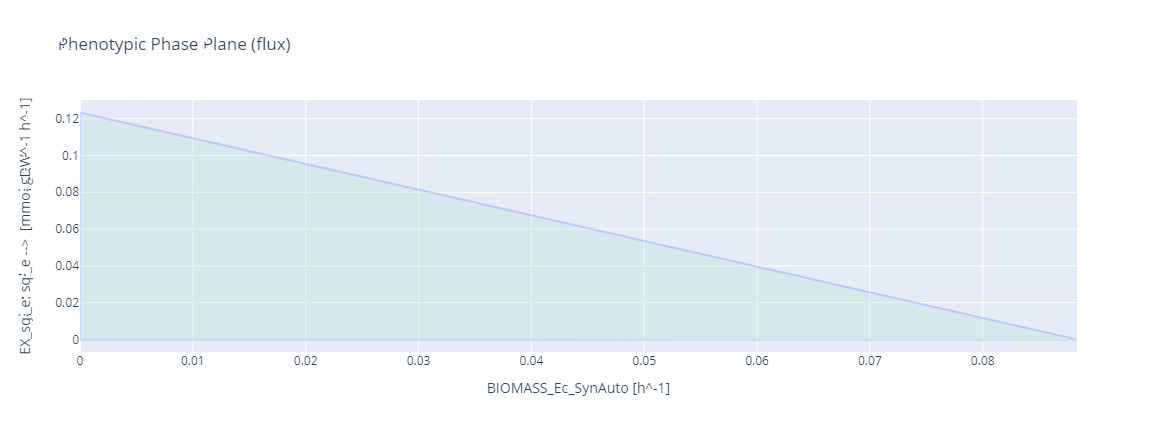

In [10]:
# Autotrophic conditions

modelM.medium=mediumAuto
modelM.optimize()
plotter = PlotlyPlotter()

ppp = phenotypic_phase_plane(modelM,
                             variables=[modelM.reactions.BIOMASS_Ec_SynAuto],
                             objective=modelM.reactions.EX_sql_e)

ppp.plot(plotter)

In [11]:
# Mixotrophic conditions


#Mixo = modelM.copy()

#mediumA = Mixo.medium
#mediumA["EX_glc__D_e"] = 0.39
#mediumA["EX_co2_e"] = 0

#Mixo.medium = mediumA

#Mixo.medium
#Why copy??

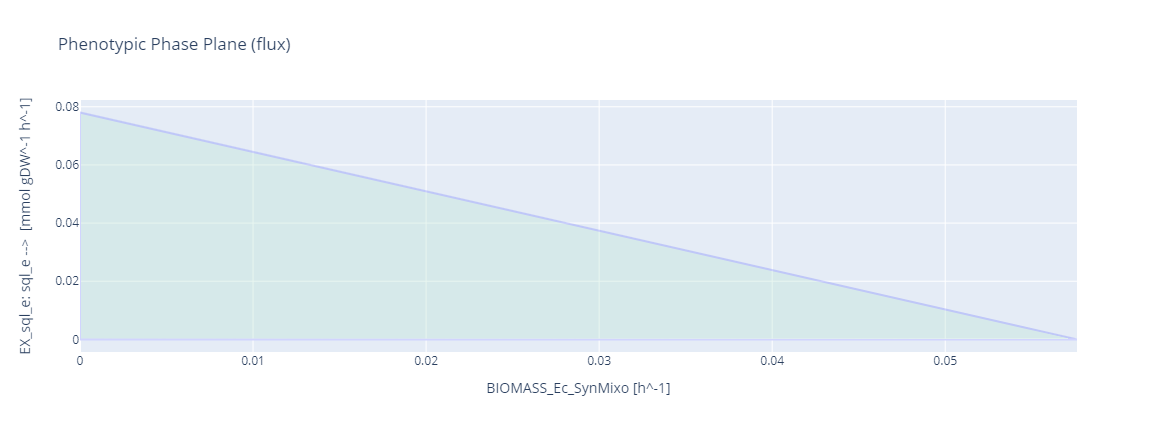

In [12]:
modelM.medium=mediumMixo
modelM.optimize()
ppp2 = phenotypic_phase_plane(modelM,
                             variables=[modelM.reactions.BIOMASS_Ec_SynMixo],
                             objective=modelM.reactions.EX_sql_e)

ppp2.plot(plotter)

In [13]:
# Anaerobic conditions

Anaerobic = modelM.copy()

mediumB = Anaerobic.medium
mediumB["EX_o2_e"] = 0.0
Anaerobic.medium = mediumB

Anaerobic.medium

Read LP format model from file C:\Users\marck\AppData\Local\Temp\tmpf9yee2vl.lp
Reading time = 0.01 seconds
: 796 rows, 1730 columns, 8330 nonzeros


{'EX_photon_e': 54.5,
 'EX_ca2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_glc__D_e': 0.39,
 'EX_no3_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_zn2_e': 1000.0}

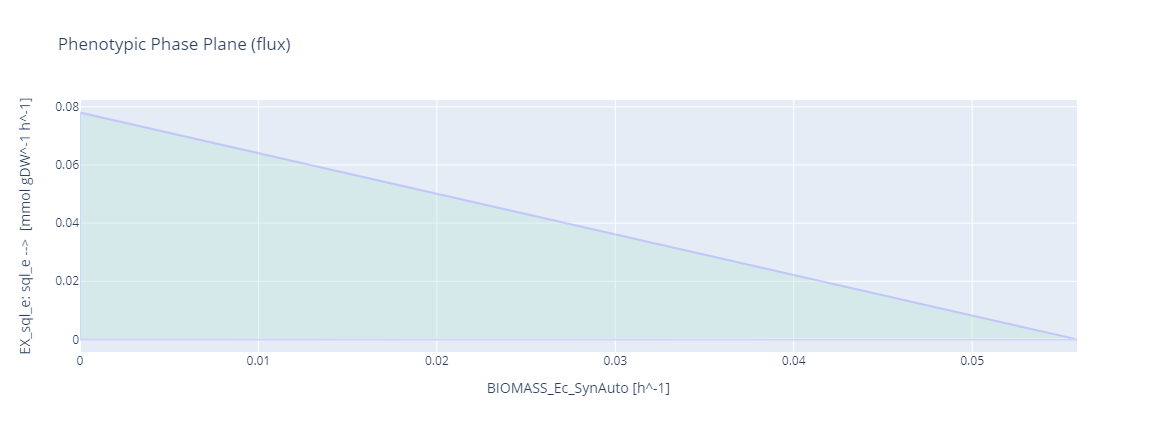

In [14]:

ppp3 = phenotypic_phase_plane(Anaerobic,
                             variables=[Anaerobic.reactions.BIOMASS_Ec_SynAuto],
                             objective=Anaerobic.reactions.EX_sql_e)

ppp3.plot(plotter)

In [15]:
# Heterotrophic conditions

#Hetero = modelM.copy()

#mediumH = Hetero.medium
#mediumH["EX_photon_e"] = 0
#mediumH["EX_glc__D_e"] = 0.85
#mediumH["EX_co2_e"] = 0
#Hetero.medium = mediumH

#Hetero.medium

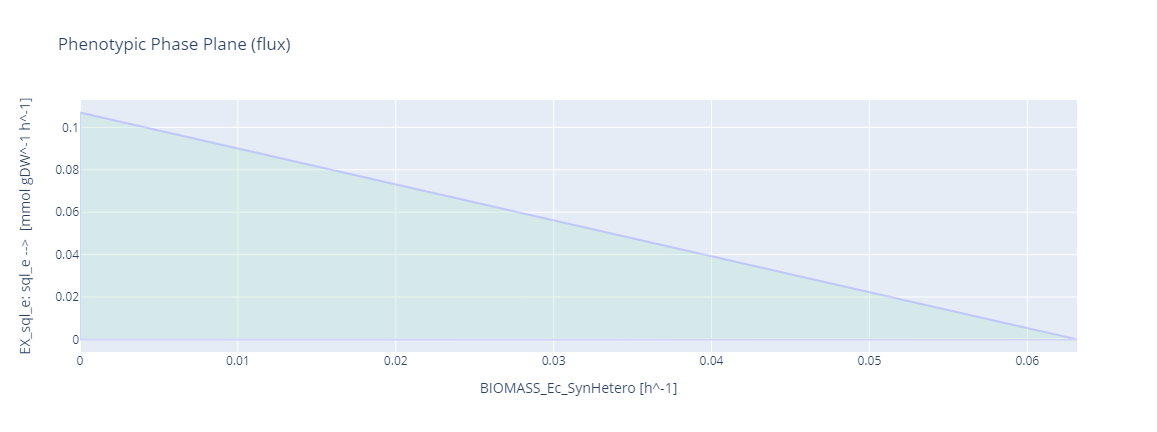

In [16]:

modelM.medium=mediumHetero
ppp4 = phenotypic_phase_plane(modelM,
                             variables=[modelM.reactions.BIOMASS_Ec_SynHetero],
                             objective=modelM.reactions.EX_sql_e)

ppp4.plot(plotter)

<a id='4.3'></a>
### 4.3 Alternative production pathways

<div style="text-align: justify"> 
In <i>Synechocystis sp.</i> PCC 6803, squalene production is achieved through the sesquiterpenoid-triterpenoid biosynthesis pathway which uses farnesyl diphosphate (FPP) as the main precursor. The generation of the precursor, FPP, can be derived through two different routes, the mevalonate (MVA) pathway or the methylerythritol 4-phosphate (MEP) pathway. However, according to the genome analysis, <i>Synechocystis sp.</i> PCC 6803 does not possess the enzymatic reactions required for the MVA pathway, thus making the MEP pathway the main flux stream towards squalene biosynthesis. Heterologous expression of MVA pathway reactions can provide an additional side-stream beside the MEP pathway, thus increasing the flux towards the squalene production as illustrated in <i>Figure 4</i> and <i>Figure 5</i>. In addition, the incorporation of the MVA pathway also enables the utilizaiton of acetyl-CoA as an alternative substrate besides glyceraldehyde-3-phosphate which is used in the MEP pathway. The implementation of MVA and MEP coupling is already shown to be an effective strategy for increasing flux towards isopehtenyl-diphosphate (IPP) and deimethylallyl-diphosphate (DMAPP) in <i>Synechocystis sp.</i> PCC 6803, which act as a precursor for squalene production <i>(Bentley et al., 2014)</i>.
</div>

<center><img src="https://raw.githubusercontent.com/27410/27410-group-assigment-group18_squalene_production/main/Figures/mva-mep-no-genes.png"/></center>

<center> Figure 4: Squalene synthesis through the MVA and MEP pathways <i>(Paramasivan et al., 2022)</i> <center>

<center><img src="Figures/fluxmva2.png"/></center>
<center> Figure 5: Pathway visualization of squalene production in modified MVA pathway iJN678 model generated through the Fluxer software <center>

In [17]:
modelMVA= read_sbml_model("iJN678mva.xml")
modelMVA

<Model iJN678 at 0x20a083e3040>

In [18]:
# Compare the change in max biomass and squalene formation after MVA expression   
%run MVAvsMEP.ipynb

-----------------------------------------
Squalene production before MVA expression
-----------------------------------------
Maximum productivity before MVA: 0.12333333333333331 mmol/gDW*h
Maximum theoretical yield after MVA: 0.033333333333333326 mmol-sql/mmol-co2

----------------------------------------
Squalene production after MVA expression
----------------------------------------
Maximum productivity after MVA: 0.12333333333333331 mmol/gDW*h
Maximum theoretical yield after MVA: 0.033333333333333326 mmol-sql/mmol-co2

----------------------------------------
Percentage change in squalene production
----------------------------------------
Change in max productivity: 0.0 %
Change in max theoretical yield: 0.0 %


<a id='4.4'></a>
### 4.4 Optimization through gene modulation strategies

<a id='4.4.1'></a>
#### 4.4.1 OptGene

<div style="text-align: justify"> 
To assess the possible gene knockouts, the OptGene algorithm has been run. From the results, the top five strain designs have been analysed in terms of maximum yield, plotting the phenotypic phase planes for each. However, it must be noted that, due to complications during the running of the algorithm, the reaction here studied is the first of the pathway, that is, Pyruvate Kinase. An increase in its flux would theoretically increase the flux of the whole pathway, thus producing more squalene.
</div>

In [19]:
modelM.medium=mediumHetero

modelM.objective = "BIOMASS_Ec_SynHetero"


In [20]:
optgene = OptGene(modelM)

In [21]:
OptGeneMod = optgene.run(target=modelM.reactions.PYK,
                     biomass=modelM.reactions.BIOMASS_Ec_SynHetero,
                     substrate=modelM.metabolites.glc__D_e,
                     max_evaluations=5000,
                     plot=False)
OptGeneMod

Starting optimization at Wed, 30 Nov 2022 23:06:03


C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 1), ('y', 0)



HBox()

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 2), ('y', 1)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 3), ('y', 2)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 4), ('y', 3)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 5), ('y', 4)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 6), ('y', 5)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarn

Finished after 00:03:24


HBox()

In [22]:
sort=OptGeneMod.data_frame.sort_values('fva_max')
top=sort.head(6)
top

reactions  \
0                                            (FNOR,)   
4                         (FNOR, COBALT2abcpp, PSII)   
3                             (TRSARr, FNOR, HIBDkt)   
2                                 (PSI_2, FNOR, PSI)   
5  (GLYabcpp, ALAabcpp, PROabcpp, SERabcpp, FNOR,...   
1                                       (FNOR, TRDR)   

                                genes  size  fva_min   fva_max  target_flux  \
0         ((petF,), (petH,), (isiB,))     1      0.0  2.287501          0.0   
4            ((slr0797, petH, psbM),)     3      0.0  2.287532          0.0   
3                     ((mmsB, petH),)     2      0.0  2.287532          0.0   
2                     ((petH, psaL),)     2      0.0  2.287532          0.0   
5               ((psaK, livF, petH),)     3      0.0  2.287532          0.0   
1  ((slr0600, petH), (slr0600, isiB))     2      0.0  2.295376          0.0   

   biomass_flux  yield  fitness  
0      0.049773    0.0      0.0  
4      0.049773    0.0      0.0  
3      0.049773    0.0      0.0  
2      0.049773    0.0      0.0  
5      0.049773    0.0      0.0  
1      0.049613    0.0      0.0

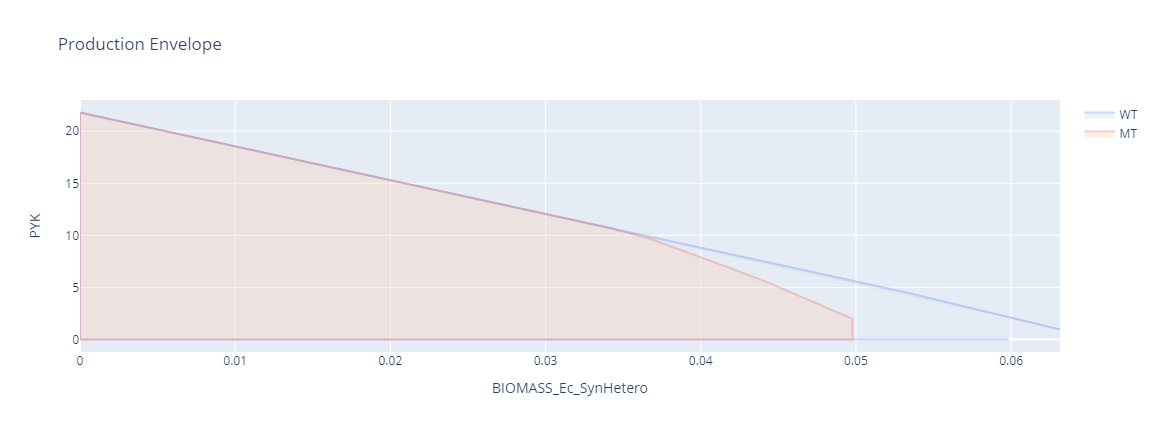

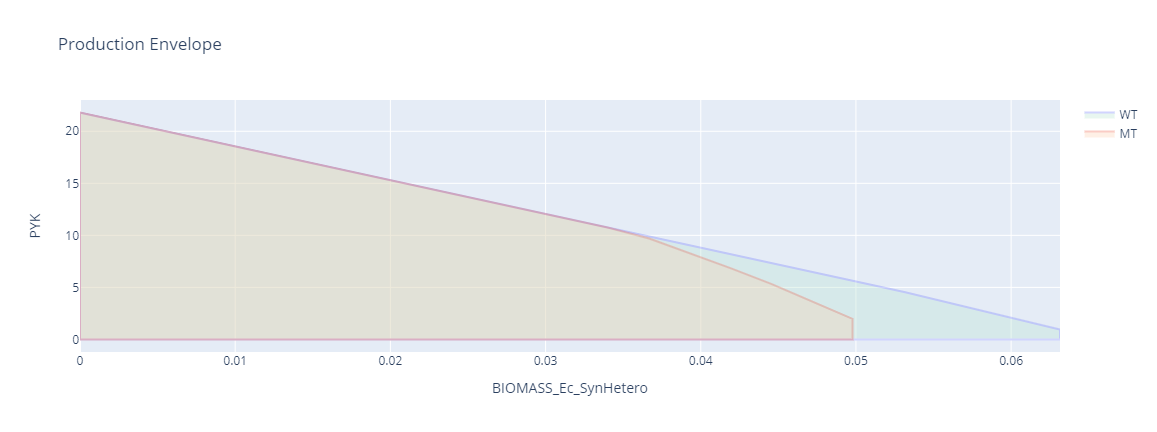

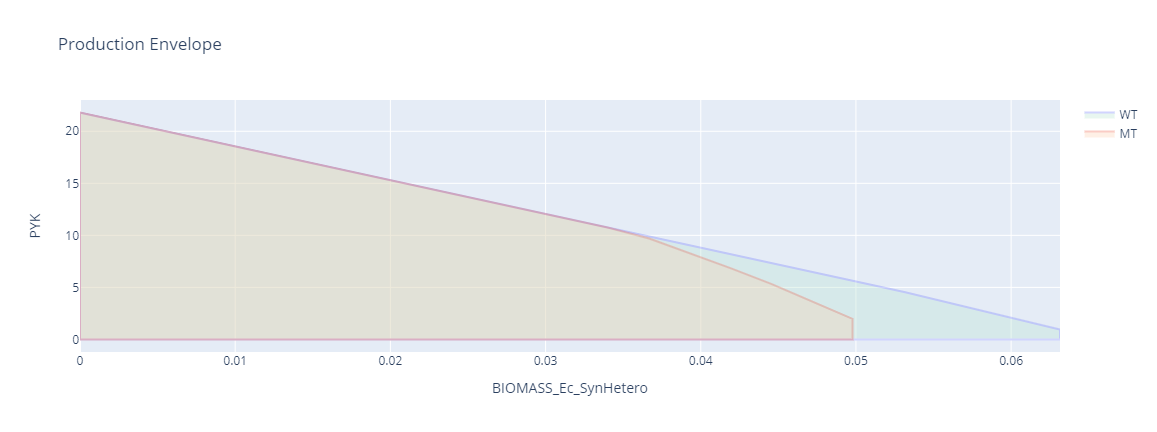

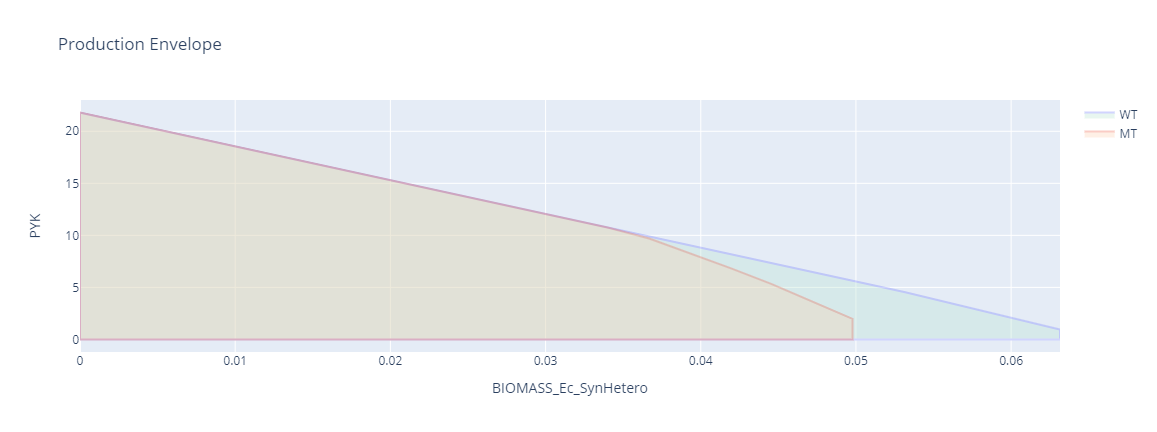

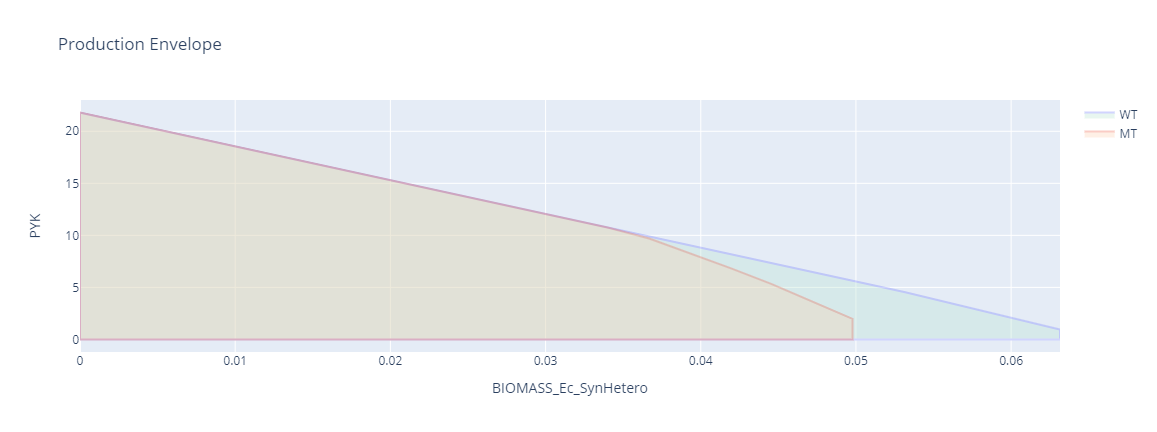

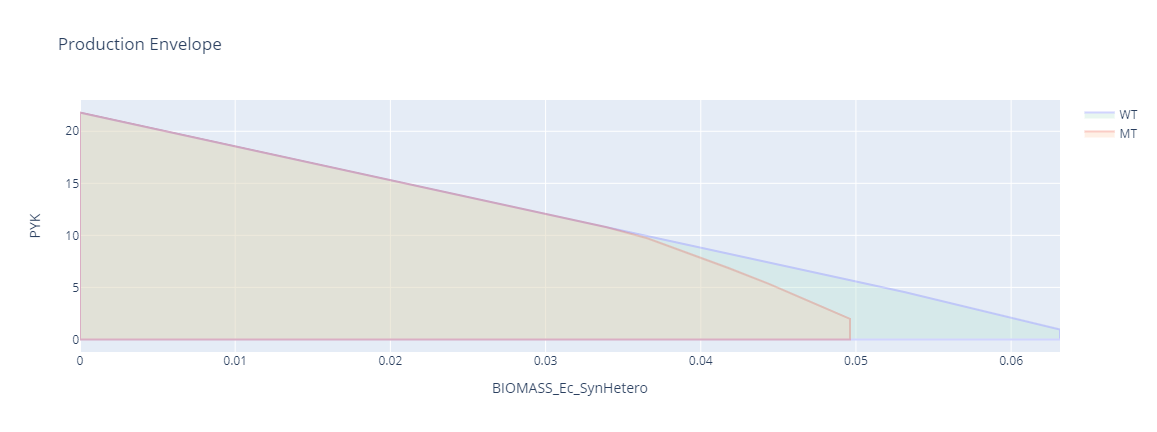

In [23]:
for i in top.index:
    OptGeneMod.plot(plotter, i)

<div style="text-align: justify"> 
Similarly, the same process was conducted with the model with the MVA pathway. This time, also using the first reaction of the pathway, Acetyl-CoA synthetase, due to the same computational limitations.
</div>

In [24]:
modelMVA.objective = "BIOMASS_Ec_SynHetero"
modelMVA.medium=mediumHetero

optgene = OptGene(modelMVA)

In [25]:
OptGeneMVA = optgene.run(target=modelMVA.reactions.ACS,
                     biomass=modelMVA.reactions.BIOMASS_Ec_SynHetero,
                     substrate=modelMVA.metabolites.glc__D_e,
                     max_evaluations=5000,
                     plot=False)
OptGeneMVA

Starting optimization at Wed, 30 Nov 2022 23:09:45


C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 1), ('y', 0)



HBox()

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 2), ('y', 1)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 3), ('y', 2)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 4), ('y', 3)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 5), ('y', 4)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 6), ('y', 5)

C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarn

Finished after 00:03:01


C:\Users\marck\anaconda3\lib\site-packages\bokeh\models\sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 25), ('y', 24)



HBox()

In [26]:
sort=OptGeneMVA.data_frame.sort_values('fva_max')
top=sort.head(6)
top

reactions       genes  size  fva_min   fva_max  target_flux  biomass_flux  \
0   (ACKr,)  ((ackA,),)     1      0.0  0.013059       0.0123      0.063223   
1   (PTAr,)   ((pta,),)     1      0.0  0.013059       0.0123      0.063223   

      yield   fitness  
0  0.014471  0.000915  
1  0.014471  0.000915

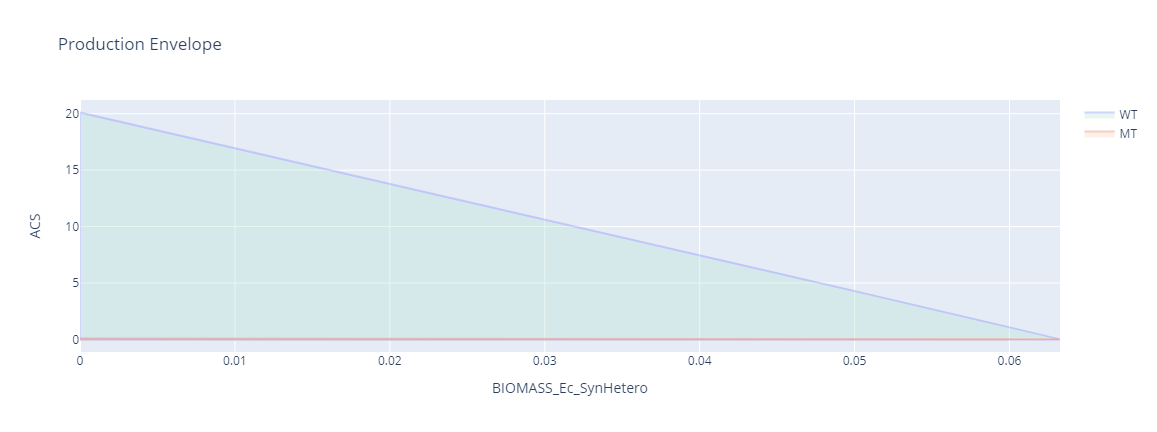

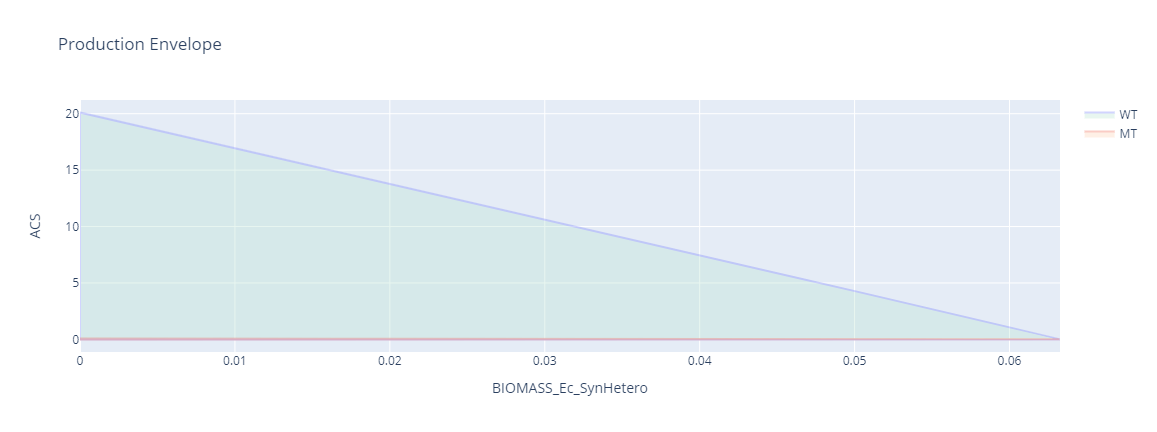

In [27]:
for i in top.index:
    OptGeneMVA.plot(plotter, i)

It can be seen that, for both models, the top 5 results from the algorithm do not significantly increase the production of squalene. In fact, they only influence the maximum growth of the organisms, ensuring that it can not continue growing in order to reinforce squalene production.

<a id='4.4.2'></a>
#### 4.4.2 Flux Scanning based on Enforced Objective Flux

<div style="text-align: justify"> 
Additionally, the up- or down-regulation of certain genes can also theoretically improve the production of squalene. Therefore, a Flux Scanning based on Enforced Objective Flux analysis has been carried out for both models.
</div>

In [28]:
modelM.objective='EX_sql_e'
modelM.medium=mediumAuto
fseofM = FSEOF(modelM)
solM=fseofM.run(target=modelM.reactions.EX_sql_e)
dfM=solM.data_frame
dfM= dfM.sort_values([1], ascending = False)

In [29]:
dfM

1          2          3          4          5          6   \
PHOtex       54.500000  54.500000  54.500000  54.500000  54.500000  54.500000   
PHOtpp       54.500000  54.500000  54.500000  54.500000  54.500000  54.500000   
PSII         13.208538  13.350371  13.492204  13.625000  13.625000  13.625000   
GLUDy         9.674479  10.048618  10.422758  10.773163  10.774796  10.776429   
GLMS_syn      9.674479  10.048618  10.422758  10.773163  10.774796  10.776429   
GLNS          9.674479  10.048618  10.422758  10.773163  10.774796  10.776429   
O2tu          6.604269   6.675185   6.746102   6.812500   6.812500   6.812500   
H2Otpp        5.882558   6.098390   6.314223   6.516848   6.525387   6.533925   
FBP           2.930392   2.900792   2.871192   2.844373   2.858414   2.872455   
CBFC2pp       2.830066   3.076732   3.323398   3.554771   3.561412   3.568053   
NDH1_4pp      2.830066   3.076732   3.323398   3.554771   3.561412   3.568053   
CYO1bpp_syn   2.830066   3.076732   3.323398   3.554771   3.561412   3.568053   
ATPS4rpp_1    1.828050   1.986532   2.145015   2.293667   2.297848   2.302029   
IPDPS_syn     0.732598   0.725198   0.717798   0.710398   0.702998   0.695598   
NDPK3         0.732598   0.725198   0.717798   0.710398   0.702998   0.695598   
PYK5          0.732598   0.725198   0.717798   0.711788   0.726209   0.740629   
ENO           0.732598   0.725198   0.717798   0.711788   0.726209   0.740629   
IPDDI         0.244199   0.241733   0.239266   0.236799   0.234333   0.231866   
EX_sql_e      0.122100   0.120866   0.119633   0.118400   0.117166   0.115933   
PHBS_syn      0.000000   0.000000   0.000000   0.000695   0.011605   0.022516   
AACOAR_syn    0.000000   0.000000   0.000000   0.000695   0.011605   0.022516   
POR_syn       0.000000   0.000000   0.000000   0.001390   0.023211   0.045031   
ACACT1r       0.000000   0.000000   0.000000   0.000695   0.011605   0.022516   
PGM          -0.732598  -0.725198  -0.717798  -0.711788  -0.726209  -0.740629   
NDPK9        -0.732598  -0.725198  -0.717798  -0.711788  -0.726209  -0.740629   
TALA         -1.465196  -1.450396  -1.435596  -1.422186  -1.429207  -1.436227   
FBA          -2.930392  -2.900792  -2.871192  -2.844373  -2.858414  -2.872455   
O2tpp        -6.604269  -6.675185  -6.746102  -6.812500  -6.812500  -6.812500   
H2Otu_syn   -13.208538 -13.350371 -13.492204 -13.625000 -13.625000 -13.625000   

                    7          8          9          10  
PHOtex       54.500000  54.500000  54.500000  54.500000  
PHOtpp       54.500000  54.500000  54.500000  54.500000  
PSII         13.625000  13.625000  13.625000  13.625000  
GLUDy        10.778062  10.779696  10.781329  10.782962  
GLMS_syn     10.778062  10.779696  10.781329  10.782962  
GLNS         10.778062  10.779696  10.781329  10.782962  
O2tu          6.812500   6.812500   6.812500   6.812500  
H2Otpp        6.542464   6.551002   6.559541   6.568079  
FBP           2.886496   2.900537   2.914578   2.928619  
CBFC2pp       3.574694   3.581335   3.587976   3.594617  
NDH1_4pp      3.574694   3.581335   3.587976   3.594617  
CYO1bpp_syn   3.574694   3.581335   3.587976   3.594617  
ATPS4rpp_1    2.306210   2.310392   2.314573   2.318754  
IPDPS_syn     0.688198   0.680798   0.673398   0.665998  
NDPK3         0.688198   0.680798   0.673398   0.665998  
PYK5          0.755050   0.769470   0.783891   0.798311  
ENO           0.755050   0.769470   0.783891   0.798311  
IPDDI         0.229399   0.226933   0.224466   0.221999  
EX_sql_e      0.114700   0.113466   0.112233   0.111000  
PHBS_syn      0.033426   0.044336   0.055246   0.066156  
AACOAR_syn    0.033426   0.044336   0.055246   0.066156  
POR_syn       0.066852   0.088672   0.110493   0.132313  
ACACT1r       0.033426   0.044336   0.055246   0.066156  
PGM          -0.755050  -0.769470  -0.783891  -0.798311  
NDPK9        -0.755050  -0.769470  -0.783891  -0.798311  
TALA         -1.443248  -1.450268  -1.457289  -1.464309  
FBA          -2.886496 

Text(0.5, 1.0, 'Flux scanning based on Enforced Objective Flux (iJN678mod)- EX_sql_e')

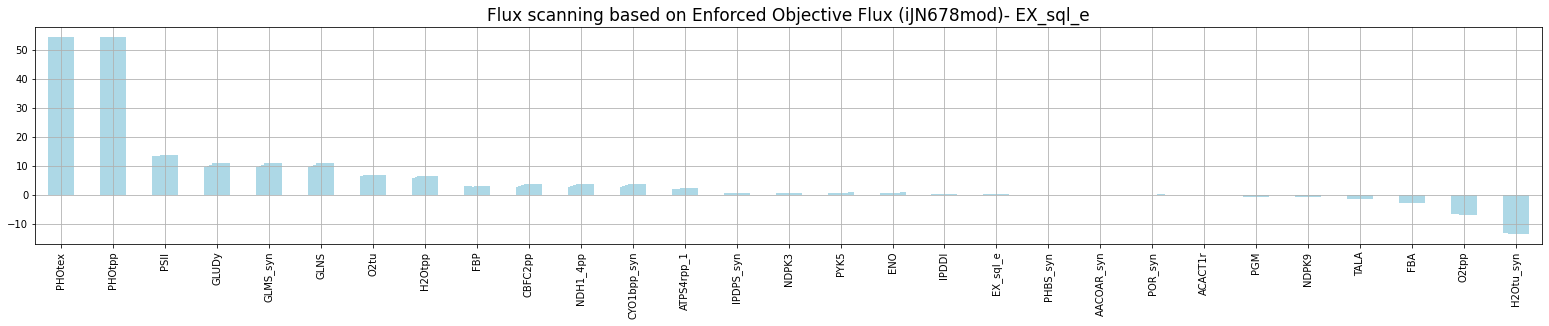

In [30]:
fig = dfM.plot(legend=None, kind='bar', color={'lightblue'}, figsize=(27, 4), grid =True);
fig.set_title('Flux scanning based on Enforced Objective Flux (iJN678mod)- EX_sql_e', size=17)

From the FSEOF, we obtain several reactions that can be targeted in order to increase the production of squalene. First amongst them are the electron transport chain reactions and the photon transport fluxes.  However, the latter will not be studied, as they are relevant to culture conditions and not to the inherent organization of the metabolic structure.

In [31]:
FoldChange=[1,1.25,1.5]
modelM.medium=mediumAuto
modelM.objective='EX_sql_e'
modelM.optimize().fluxes['GLUDy']

9.300238095238072

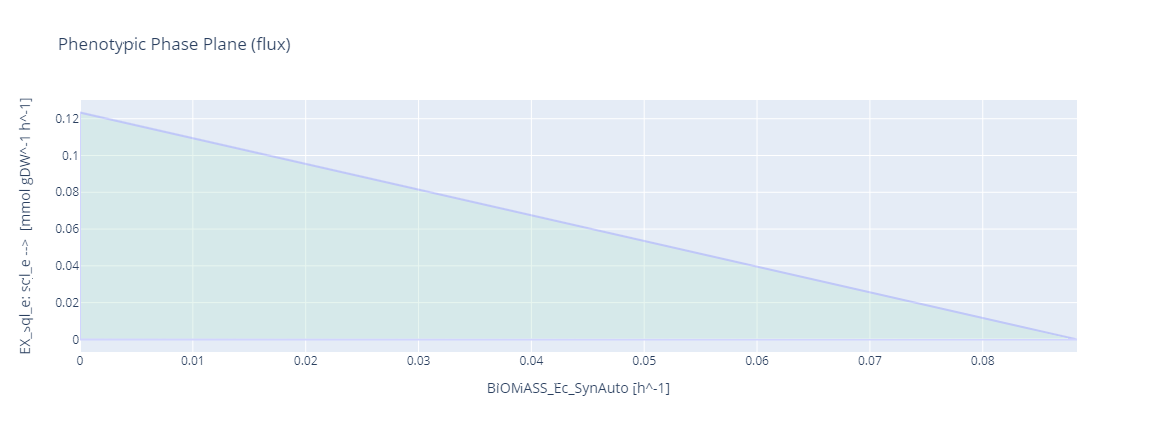

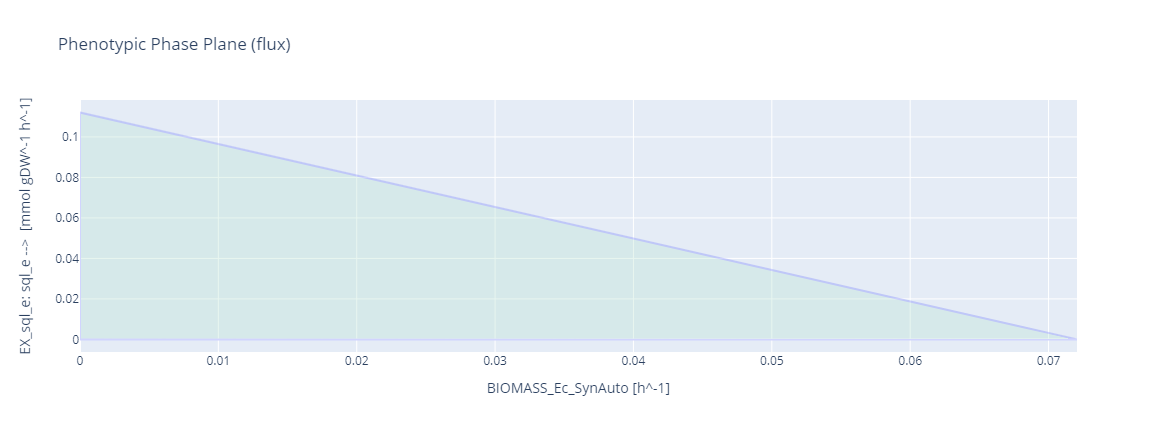

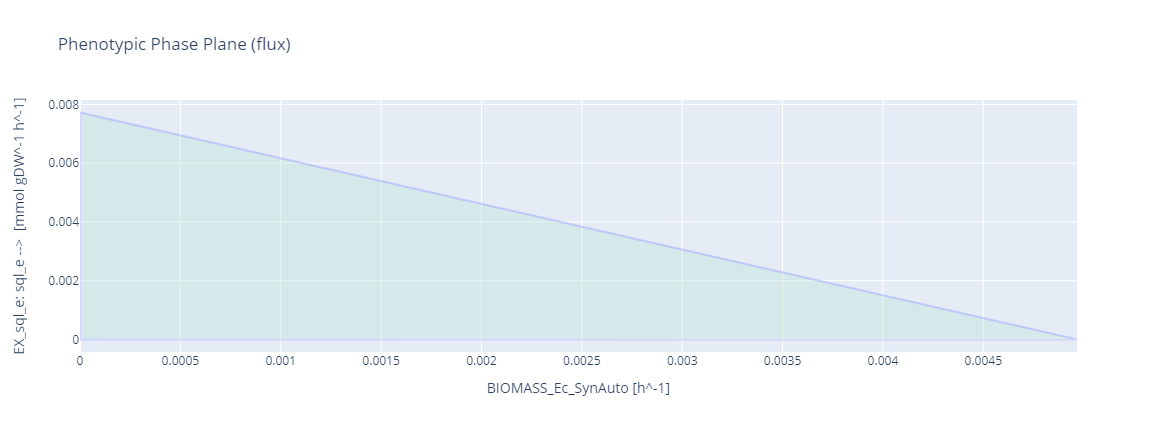

In [32]:
for i in FoldChange:
        modelM.medium=mediumAuto
        modelM.objective='EX_sql_e'
        b=modelM.optimize().fluxes['CBFCu']
        modelM.reactions.CBFCu.bounds= i*b,i*b     
        ppp = phenotypic_phase_plane(modelM,
                             variables=[modelM.reactions.BIOMASS_Ec_SynAuto],
                             objective=modelM.reactions.EX_sql_e)
        ppp.plot(plotter)       

In [33]:
fseofMVA = FSEOF(modelMVA)
solMVA=fseofMVA.run(target=modelMVA.reactions.EX_sql_e)
dfMVA=solMVA.data_frame
dfMVA= dfMVA.sort_values([1], ascending = False)

In [34]:
dfMVA

1         2         3         4         5         6   \
ENO          1.211553  1.234532  1.257511  1.280489  1.335421  1.445368   
GAPD         1.077460  1.112787  1.148115  1.183442  1.176432  1.096528   
PYK4         1.000143  1.042591  1.085039  1.127487  1.202622  1.334037   
POR_syn      0.851224  0.907386  0.963548  1.019710  1.109077  1.255615   
Htex         0.727474  0.802599  0.877723  0.952847  1.025896  1.095373   
FBA          0.453315  0.467843  0.482372  0.496900  0.505684  0.504579   
PFK          0.453315  0.467843  0.482372  0.496900  0.505684  0.504579   
TPI          0.443148  0.458612  0.474077  0.489541  0.499297  0.499224   
PPA          0.236388  0.280212  0.324036  0.367860  0.411071  0.453228   
PRUK         0.134093  0.121745  0.109396  0.097047  0.121610  0.209728   
PGI          0.082630  0.087288  0.091947  0.096605  0.157321  0.314552   
R_MVA3       0.070432  0.129539  0.188646  0.247753  0.306824  0.365833   
R_MVA1       0.070432  0.129539  0.188646  0.247753  0.306824  0.365833   
R_MVA4       0.070432  0.129539  0.188646  0.247753  0.306824  0.365833   
R_MVA5       0.070432  0.129539  0.188646  0.247753  0.306824  0.365833   
ACACT1r      0.070432  0.129539  0.188646  0.247753  0.306824  0.365833   
R_MVA2       0.070432  0.129539  0.188646  0.247753  0.306824  0.365833   
NDPK2        0.032961  0.029926  0.026890  0.023855  0.020705  0.017358   
GRTT         0.022614  0.042396  0.062178  0.081960  0.101732  0.121490   
IPDDI        0.022614  0.042396  0.062178  0.081960  0.101732  0.121490   
DMATT        0.022614  0.042396  0.062178  0.081960  0.101732  0.121490   
NDPK1        0.022350  0.020292  0.018233  0.016175  0.014039  0.011770   
EX_sql_e     0.010010  0.020021  0.030031  0.040041  0.050052  0.060062   
SQLS         0.010010  0.020021  0.030031  0.040041  0.050052  0.060062   
R_SQLt       0.010010  0.020021  0.030031  0.040041  0.050052  0.060062   
CYTK1        0.000921  0.000836  0.000752  0.000667  0.000579  0.000485   
TOCOPHOM2    0.000001  0.000001  0.000001  0.000001  0.000001  0.000000   
CDPMEK       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
RBPC         0.000000  0.000000  0.000000  0.000000  0.037378  0.139113   
MECDPDH_syn  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
MEPCT        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
MECDPS       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
IPDPS_syn    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
DXPS         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
DXPRIi       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NDPK3       -1.000580 -1.042988 -1.085395 -1.127803 -1.202896 -1.334267   
PGK         -1.077460 -1.112787 -1.148115 -1.183442 -1.176432 -1.096528   
PGM         -1.211553 -1.234532 -1.257511 -1.280489 -1.335421 -1.445368   
H2Otpp      -1.482607 -1.532335 -1.582063 -1.631792 -1.660739 -1.653908   

                   7         8         9         10  
ENO          1.555316  1.665263  1.775210  1.785085  
GAPD         1.016624  0.936720  0.856815  0.797289  
PYK4         1.465453  1.596868  1.728283  1.760193  
POR_syn      1.402152  1.548690  1.695227  1.693551  
Htex         1.164849  1.234326  1.303802  1.273459  
FBA          0.503474  0.502369  0.501264  0.508993  
PFK          0.503474  0.502369  0.501264  0.508993  
TPI          0.499152  0.499079  0.499007  0.507796  
PPA          0.495384  0.537541  0.579698  0.670489  
PRUK         0.297845  0.385963  0.474080  0.501792  
PGI          0.471783  0.629014  0.786245  0.848754  
R_MVA3       0.424842  0.483851  0.542860  0.552733  
R_MVA1       0.424842  0.483851  0.542860  0.552733  
R_MVA4       0.424842  0.483851  0.542860  0.552733  
R_MVA5       0.424842  0.483851  0.542860  0.552733  
ACACT1r      0.424842  0.483851  0.542860  0.552733  
R_MVA2       0.424842  0.483851  0.542860  0.552733  
NDPK2        0.014011  0.010663  0.007316  0.0

Text(0.5, 1.0, 'Flux scanning based on Enforced Objective Flux (MVA) - EX_sql_e')

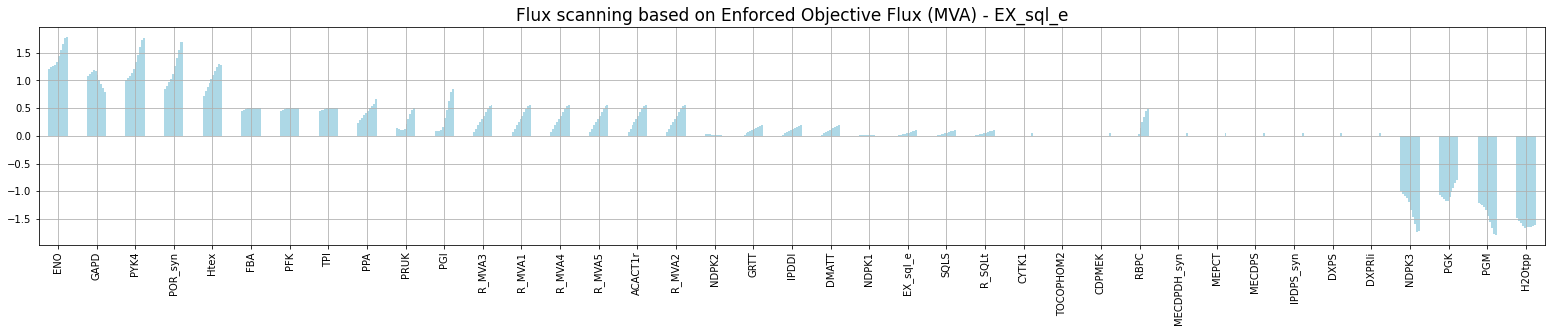

In [35]:
fig = dfMVA.plot(legend=None, kind='bar', color={'lightblue'}, figsize=(27, 4), grid =True);
fig.set_title('Flux scanning based on Enforced Objective Flux (MVA) - EX_sql_e', size=17)

In [36]:
modelMVA.medium=mediumAuto
modelMVA.objective='EX_sql_e'
modelMVA.optimize().fluxes['ENO']

0.7400000000000002

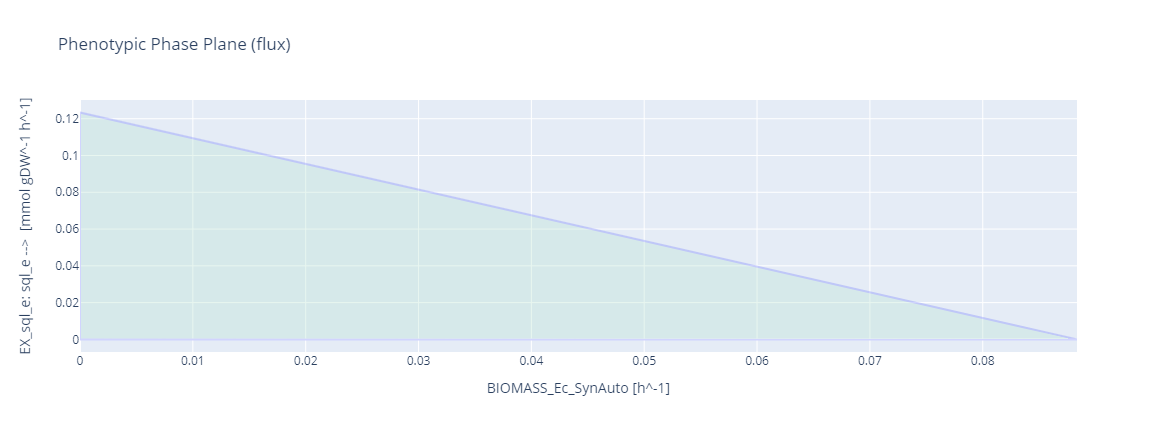

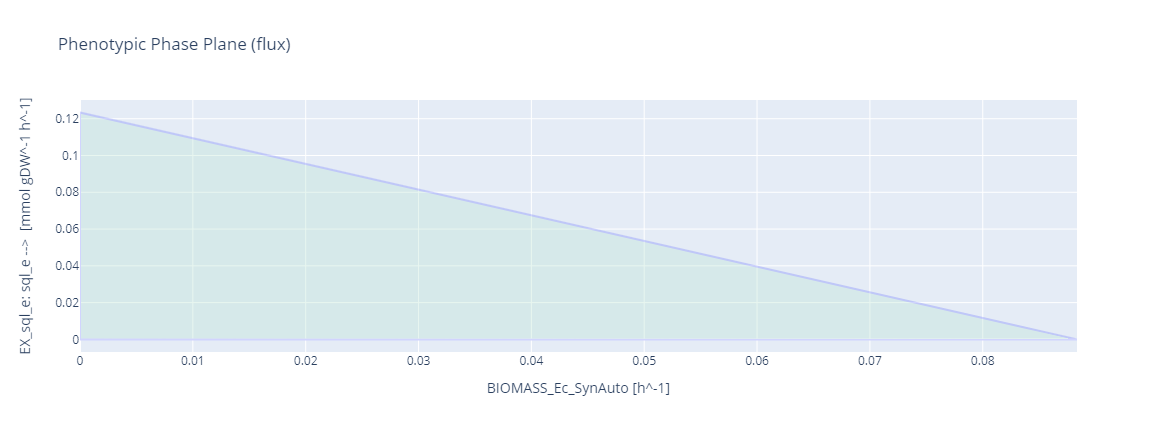

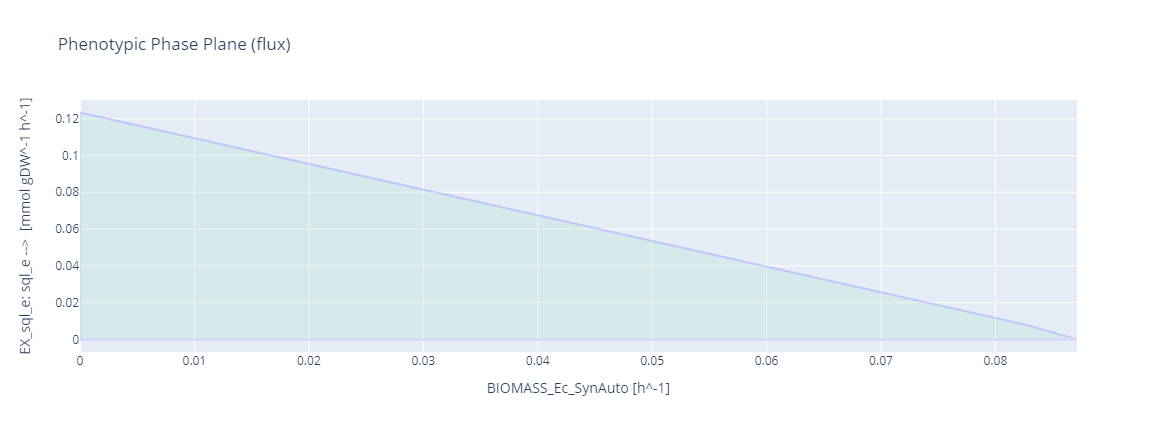

In [37]:
for i in FoldChange:
        modelMVA.medium=mediumAuto
        modelMVA.objective='EX_sql_e'
        b=modelMVA.optimize().fluxes['ENO']
        modelMVA.reactions.ENO.bounds= i*b,i*b     
        ppp = phenotypic_phase_plane(modelMVA,
                             variables=[modelMVA.reactions.BIOMASS_Ec_SynAuto],
                             objective=modelMVA.reactions.EX_sql_e)
        ppp.plot(plotter) 

It can be seen that an increase in the pathway flux (FoldChange) does not appear to improve squalene production in the studied cases.

<a id='4.4.3'></a>
#### 4.4.3 OptSwap

<div style="text-align: justify">
Several enzymatic reactions sucha as 1-Deoxy-d-xylulose-5-phosphate reductoisomerase (DXR), 4-hydroxy-3-methylbut-2-enyl diphosphate reductase (IspH) and squalene synthase (SQS) are documented to be heavily dependent on the presence of NADPH as a cofactor as illustrated in <i>Figure 6</i>, thus emphasizing the importance of having NADPH/NADP+ ratio in squalene synthesis as indicated by the articles <i>(Yajima et al. 2007)(Xiao et al. 2009)</i>.
</div>

<center><img src="https://raw.githubusercontent.com/27410/27410-group-assigment-group18_squalene_production/main/Figures/NADPH.png"/></center>

<center> Figure 6: Reactions with NADP(H)/NADP dependence on the MEP pathway. <i>(Xu et al. 2019)</i> <center>

<div style="text-align: justify">
    As a proof of concept, heterologous expression of soluble pyridine nucleotide transhydrogenase (UdhA), enzyme which catalyzes the reversible hydride transfer between NAD(H) and NADP(H) to maintain cofactor homeostasis <i>(Sánchez et al. 2006)</i>, showed to increase overall squalene production through increasing the NADPH/NADP ratio in <i>Escherichia coli</i> <i>(Xu et al. 2019)</i>. A further increase NADP(H)/NADP+ can be achieved through cofactor swapping in specific reactions. For instance, by swapping NADP(H)-to-NAD(H) in oxidation reactions and NADP+-to-NAD+ in reduction reactions, the reaction mechanism can be regulated to both minimize  NADP(H) consumption and optimize NADP(H) regeneration, thus increasing the NADP(H)/NADP+ availability for the reactions involved in squalene biosynthesis. Hence, this section is dedicated to test and determine possible cofactor swap targets in <i>Synechocystis sp. PCC 6803</i> which can be regulated for further optimization of squalene production. In order to achive this, the model objective is set to be squalene synthesis under autotrophic medium conditions (CO<sub>2</sub> as a main carbon source) and potential cofactor swap targets are determined through analyzing the model reactions by using the "CofactorSwapOptimization" algorithm. After the analysis, several of the determined cofactor swap targets were tested by carrying out NADP(H)/NADP+ to NAD(H)/NAD+ swapping and the targets which resulted in negative and positive effect on the squalene synthesis were noted down. At the end, the cofactor targets with increased squalene production are gathered in a separate notebook (PositiveCofTargets.ipynb) and used to determine the overall increase in squalene production which resulted in an increase in squalene production and biomass growth. 
</div>

In [38]:
# Loading of the model
model_orig = read_sbml_model('iJN678mod.xml')
model = model_orig.copy()
model.medium=mediumAuto

Read LP format model from file C:\Users\marck\AppData\Local\Temp\tmp9pzz11pz.lp
Reading time = 0.01 seconds
: 796 rows, 1730 columns, 8330 nonzeros


In [39]:
# Calculate max biomass and squalene production
with model:
    model.medium=mediumAuto
    base_max_growth = model.slim_optimize()
    model.objective = model.reactions.EX_sql_e
    base_max_production = model.slim_optimize()
    print("------------------------------------------------------------")
    print("Max biomass and squalene formation under normal growth rate")
    print("------------------------------------------------------------")
    print("Max biomass growth:", base_max_growth, "/h")
    print("Max squalene production:", base_max_production, "mmol/gdcw/h") 

------------------------------------------------------------
Max biomass and squalene formation under normal growth rate
------------------------------------------------------------
Max biomass growth: 0.12333333333333325 /h
Max squalene production: 0.12333333333333325 mmol/gdcw/h


In [40]:
model.solver = "glpk" 

In [41]:
# Specify biomass growth rate
biomass = model.reactions.BIOMASS_Ec_SynAuto.lower_bound = 0.04859441594166733
# Specify model objective towards squalene biosynthesis
demand = model.reactions.get_by_id("SQLS")
model.objective = demand

In [42]:
# Max biomass and squalene production after objective change
with model:
    model.medium=mediumAuto
    base_max_growth = model.slim_optimize()
    model.objective = model.reactions.EX_sql_e
    base_max_production = model.slim_optimize()
    print("------------------------------------------------------------")
    print("Max biomass and squalene formation under optimal growth rate")
    print("------------------------------------------------------------")
    print("Max biomass growth:", base_max_growth, "/h")
    print("Max squalene production:", base_max_production, "mmol/gdcw/h")

------------------------------------------------------------
Max biomass and squalene formation under optimal growth rate
------------------------------------------------------------
Max biomass growth: 0.05550007289162328 /h
Max squalene production: 0.05550007289162328 mmol/gdcw/h


In [43]:
# State the product yield calculation
py = product_yield(model.reactions.EX_sql_e, model.reactions.EX_co2_e)
#py = product_yield(model.reactions.SQLS, model.reactions.EX_glc__D_e)
#py = product_yield(model.reactions.SQLS, model.reactions.BIOMASS_Ec_SynAuto)

If needed, you can set different co-factor pairs by adding the parameter **cofactor_id_swaps=([from], [to])** which requires the metabolite identifiers in the model of the pairs that you want to swap.

Determine the co-factors in our model:

- NADH   = nadh_c
- NAD+   = nad_c
- NADPH  = nadph_c
- NADP+  = nadp_c

In [44]:
# To swap NADPH to NADH, add "cofactor_id_swaps=(['nad_c', 'nadh_c'], ['nadp_c', 'nadph_c'])" 
# inside the "CofactorSwapOptimization()"

# Remove "#" in front of the codes below to run the cell 

#optswap = CofactorSwapOptimization(model=model, objective_function=py, plot=True, cofactor_id_swaps=(['nad_c', 'nadh_c'], ['nadp_c', 'nadph_c']))
#optswap = CofactorSwapOptimization(model = model, objective_function = py)

In [45]:
# Record possible co-factor swap targets and how long it takes to determine them

# Remove "#" in front of the codes below to run the cell 

#%time
#result = optswap.run(max_size=5)
#result

##### Playing with co-factor swap targets

In [46]:
# Summary of some of the tested co-factor targets obtained from "result" variable 
# which had negative and positive influence on the biomass and squalene production.

# Some of the tested targets are determined by using glucose as a carbon instead 
# of carbon dioxide.

#-----------------------#
# NEGATIVE IMPROVEMENTS
#-----------------------#
#model.reactions.GLYCL
#model.reactions.ICDHyr
#model.reactions.DHDPRy
#model.reactions.SHK3Dr
#model.reactions.MDH
#model.reactions.ASAD

#----------------------#
# POSITIVE IMPROVEMENTS
#----------------------#
#model.reactions.GAPD
#model.reactions.FNOR
#model.reactions.EAR120y
#model.reactions.EAR60y

##### Positive improvements

In [47]:
# Implement the jupyter notebook containing all positive co-factor swap targets 
%run PositiveCofTargets.ipynb 

##### Check the swap effect

In [48]:
# Max biomass and squalene production after objective change
with model:
    model.medium=mediumAuto
    swap_max_growth = model.slim_optimize()
    model.objective = model.reactions.EX_sql_e
    swap_max_production = model.slim_optimize()
    print()
    print("----------------------------------------------------------")
    print("Max biomass and squalene formation after cofactor swapping")
    print("----------------------------------------------------------")
    print("Max biomass growth:", swap_max_growth, "/h")
    print("Max squalene production:", swap_max_production, "mmol/gdcw/h")


----------------------------------------------------------
Max biomass and squalene formation after cofactor swapping
----------------------------------------------------------
Max biomass growth: 0.03692579141839986 /h
Max squalene production: 0.0369257914184004 mmol/gdcw/h


In [49]:
# Calcualte the percentage change in max biomass growth and squalene production
print()
print("----------------------------------------------------------")
print("Percentage change in biomass and squalene formation")
print("----------------------------------------------------------")
print("Change in max boimass growth:", round((swap_max_growth-(base_max_growth))/(base_max_growth) * 100, 2), "%")
print("Change in max squalene production:", round((swap_max_production-(base_max_production))/(base_max_production) * 100, 2), "%")


----------------------------------------------------------
Percentage change in biomass and squalene formation
----------------------------------------------------------
Change in max boimass growth: -33.47 %
Change in max squalene production: -33.47 %


 <a id='4.4.4'></a>
 #### 4.4.4 Rational overexpression strategies

<div style="text-align: justify"> 
Apart from computer generated approaches, to further improve the production of squalene, targeted overexpression of certain known genes from the production pathway could also be done. The genes are selected by combining observation of the specific pathway in <i>Synechocystis</i> and literature studies on other similar microorganisms <i>(Choi et al., 2017, 2020)</i>.
</div>

In [50]:
#Model input
modelOE=read_sbml_model('iJN678mod.xml')

In [51]:
#change the culture condition to be fully autotrophic as production needed
co2OE=modelOE.reactions.get_by_id("EX_co2_e")
photonOE=modelOE.reactions.get_by_id("EX_photon_e")
hco3OE=modelOE.reactions.get_by_id("EX_hco3_e")

co2OE.bounds=(-3.7,1000.0)
hco3OE.bounds= (-3.7,1000.0)
photonOE.bounds= (-100,0)

medium = modelOE.medium
medium["EX_glc__D_e"] = 0.0
medium["EX_hco3_e"] = 0.0
medium["EX_photon_e"]=54.5
modelOE.medium = medium
print("The genes that could be overexpressed are:")
print("sll0513, encoding: Squalene synthase" , modelOE.reactions.get_by_id("SQLS"))
print("sll1945, encoding: 1-deoxy-D-xylulose 5-phosphate synthase:" , modelOE.reactions.get_by_id("DXPS"))
print("sll1556, encoding: Isopentenyl-diphosphate D-isomerase" , modelOE.reactions.get_by_id("IPDDI"))
print("pys, encoding: Geranyltranstransferase" , modelOE.reactions.get_by_id("GRTT"))

The genes that could be overexpressed are:
sll0513, encoding: Squalene synthase SQLS: 2.0 frdp_c + h_c + nadph_c --> nadp_c + 2.0 ppi_c + sql_c
sll1945, encoding: 1-deoxy-D-xylulose 5-phosphate synthase: DXPS: g3p_c + h_c + pyr_c --> co2_c + dxyl5p_c
sll1556, encoding: Isopentenyl-diphosphate D-isomerase IPDDI: ipdp_c <=> dmpp_c
pys, encoding: Geranyltranstransferase GRTT: grdp_c + ipdp_c --> frdp_c + ppi_c


In [52]:
#change objective to squalene production
modelOE.objective = "EX_sql_e"
print("The theoretical maximum Squalene production rate is: ", modelOE.optimize().objective_value, "mmol/gdcw/h")
print("The CO2, carbon source, uptake rate is: ", -modelOE.optimize().fluxes['EX_co2_e'], "mmol/gdcw/h")
print("The biomass production under this condition is: " , modelOE.optimize().fluxes['BIOMASS_Ec_SynAuto'], "/h")

The theoretical maximum Squalene production rate is:  0.12333333333333331 mmol/gdcw/h
The CO2, carbon source, uptake rate is:  3.7 mmol/gdcw/h
The biomass production under this condition is:  0.0 /h


In [53]:
modelOE.summary()

The objective of the model is now changed to producing squalene from using CO<sub>2</sub> as carbon source.

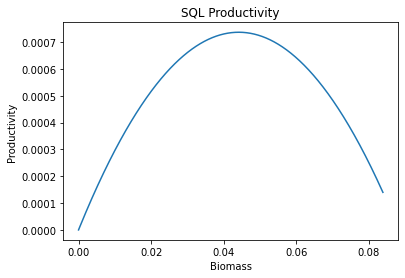

In [54]:
x=[]
y=[]
z=[]
k=[]
Biomass=[]
Productivity=[]
SQL=[]
optimum_value=[]
with modelOE:
        medium = modelOE.medium
        modelOE.objective = "EX_sql_e"
        optimum=modelOE.optimize().objective_value
        i=0.05
        while i<1:
            FVA=flux_variability_analysis(modelOE,modelOE.reactions.BIOMASS_Ec_SynAuto,fraction_of_optimum=i)
            Biomass.append(FVA.maximum.item())
            Productivity.append(-i*optimum*FVA.maximum.item()/modelOE.optimize().fluxes['EX_co2_e'])
            SQL.append(i*optimum)
            optimum_value.append(i)
            i+=0.0001 
        x.append(Biomass)
        y.append(Productivity)
        z.append(SQL)
        k.append(optimum_value)

import matplotlib.pyplot as plt
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],y[i])
    plt.xlabel("Biomass")
    plt.ylabel("Productivity")
    plt.title('SQL Productivity') 
plt.show()

<div style="text-align: justify"> 
The plot shows the productivity vs biomass. As it can be seen, the productivity reaches its maximum when biomass is controlled at a medium level.
</div>

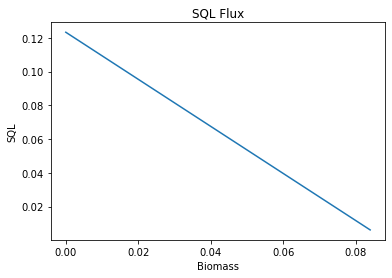

In [55]:
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],z[i])
    plt.xlabel("Biomass")
    plt.ylabel("SQL")
    plt.title('SQL Flux') 
plt.show()

<div style="text-align: justify"> 
The plot shows the squalene flux vs biomass. As it can be seen, the squalene production decreases as biomass production increases. 
</div>

In [56]:
Biomass_sorted,Productivity_sorted,SQLsorted,optimum_value_sorted = zip(*sorted(list(zip(Biomass, Productivity,SQL,optimum_value)), key=lambda item: item[1], reverse=True))
print("The highest productivity will be reached when:")
print("growth rate is ", Biomass_sorted[1], "/h,")
print("and the corresponding productivity will be", Productivity_sorted[1], "mol/mol/h")
print("The squalene production rate will be",SQLsorted[1], "mmol/gdcw/h." )
print("The optimum value set for production of SQL is",  optimum_value_sorted[1])

The highest productivity will be reached when:
growth rate is  0.04418548848347748 /h,
and the corresponding productivity will be 0.0007362775230962886 mol/mol/h
The squalene production rate will be 0.061654333333328495 mmol/gdcw/h.
The optimum value set for production of SQL is 0.4998999999999609


<div style="text-align: justify"> 
The squalene bounds are set to a fixed value, in order to make sure the desired biomass flux can be achieved when objective is set to squalene production.
</div>

In [57]:
#set the bounds of SQLS
modelOE.reactions.get_by_id('SQLS').bounds = (SQLsorted[1],SQLsorted[1])
print("The optimal fluxes of the reaction corresponding to the overexpression genes are:")
print("For Squalene synthase: ", modelOE.optimize().fluxes['SQLS'])
print("For 1-deoxy-D-xylulose 5-phosphate synthase:" , modelOE.optimize().fluxes['DXPS'])
print("For Isopentenyl-diphosphate D-isomerase" , modelOE.optimize().fluxes["IPDDI"], "#reversible reaction")
print("For Geranyltranstransferase" , modelOE.optimize().fluxes["GRTT"])

The optimal fluxes of the reaction corresponding to the overexpression genes are:
For Squalene synthase:  0.061654333333328495
For 1-deoxy-D-xylulose 5-phosphate synthase: 0.3699260000000484
For Isopentenyl-diphosphate D-isomerase 0.12330866666665699 #reversible reaction
For Geranyltranstransferase 0.12330866666665699


In [58]:
#To compare with model optimised for cell growth
model_growth=read_sbml_model('iJN678mod.xml')  
model_growth.objective = "BIOMASS_Ec_SynAuto"

print("Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:")
print("For Squalene synthase: the flux increased from", model_growth.optimize().fluxes['SQLS'], "to", modelOE.optimize().fluxes['SQLS'])
print("For 1-deoxy-D-xylulose 5-phosphate synthase, flux increased by:" , modelOE.optimize().fluxes['DXPS']*100/model_growth.optimize().fluxes['DXPS'], "%")
ipddiflux=flux_variability_analysis(model_growth,model_growth.reactions.get_by_id("IPDDI"),fraction_of_optimum=1)
ipddi_increase = (modelOE.optimize().fluxes["IPDDI"]-ipddiflux.minimum.item())*100/(model_growth.optimize().fluxes["IPDDI"]-ipddiflux.minimum.item())
print("For Isopentenyl-diphosphate D-isomerase , flux increased by:", ipddi_increase, "%, in the direction of favouring Isopentenyl diphosphate")
print("For Geranyltranstransferase, flux increased by:" , modelOE.optimize().fluxes["GRTT"]*100/model_growth.optimize().fluxes["GRTT"], "%")

Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:
For Squalene synthase: the flux increased from 0.0 to 0.061654333333328495
For 1-deoxy-D-xylulose 5-phosphate synthase, flux increased by: 3469.2279622194046 %
For Isopentenyl-diphosphate D-isomerase , flux increased by: 1231.3993648062046 %, in the direction of favouring Isopentenyl diphosphate
For Geranyltranstransferase, flux increased by: 4623.79591479929 %


<div style="text-align: justify"> 
Similar to the productivity analysis described above, comparable results could be obtained by either applying a constrain to the flux of biomass production and squalene production, or define a correlation between the two by using quadratic objective function. 
<br>
<br>The following section shows the process of applying constrains to ensure the ratio between biomass flux and squalene flux equals to (maximum growth rate/maximum production rate). Then Flux Variability Analysis will be applied to the two conditions where one is the non-optimised model the other model is optimised for growth.
</div>

In [59]:

#Model input and change the medium composition for autotrophic 
modelQO=read_sbml_model('iJN678mod.xml')
co2QO=modelQO.reactions.get_by_id("EX_co2_e")
photonQO=modelQO.reactions.get_by_id("EX_photon_e")
hco3QO=modelQO.reactions.get_by_id("EX_hco3_e")

co2QO.bounds=(-3.7,1000.0)
hco3QO.bounds= (-3.7,1000.0)
photonQO.bounds= (-100,0)

medium = modelQO.medium
medium["EX_glc__D_e"] = 0.0
medium["EX_hco3_e"] = 0.0
medium["EX_photon_e"]=54.5
modelQO.medium = medium


In [60]:
modelQO.objective = "BIOMASS_Ec_SynAuto"
max_growth_rate = modelQO.optimize().objective_value
modelQO.objective = "EX_sql_e"
max_production_rate = modelQO.optimize().objective_value
ratio = max_production_rate/max_growth_rate
print ("The maximum growth rate is: ", max_growth_rate, 
       ", the maximum production rate is: ", max_production_rate, 
       'the ratio set between production flux and biomass is ', ratio)


The maximum growth rate is:  0.08835348353030308 , the maximum production rate is:  0.12333333333333306 the ratio set between production flux and biomass is  1.3959079869333364


In [61]:
#To induce the constrain
ratio_flux = modelQO.problem.Constraint(
    modelQO.reactions.get_by_id('EX_sql_e').flux_expression - ratio* modelQO.reactions.get_by_id("BIOMASS_Ec_SynAuto").flux_expression,
    lb=0,
    ub=0)
modelQO.add_cons_vars(ratio_flux)

In [62]:
#Now set the model objective to be squalene production
modelQO.objective = "EX_sql_e"

print ("The growth rate after applying the constrain is: ", modelQO.optimize().fluxes['BIOMASS_Ec_SynAuto'], 
       ". The squalene production rate after applying the constrain is: ", modelQO.optimize().fluxes['EX_sql_e'])

The growth rate after applying the constrain is:  0.04417669745895346 . The squalene production rate after applying the constrain is:  0.06166660481929076


In [63]:
#fva for optimised constrain model
reactions_QO = [modelQO.reactions.SQLS, modelQO.reactions.DXPS, modelQO.reactions.IPDDI,
     modelQO.reactions.GRTT, modelQO.reactions.BIOMASS_Ec_SynAuto]
fva_QO = flux_variability_analysis(modelQO, reaction_list = reactions_QO, fraction_of_optimum=1)
fva_QO

minimum   maximum
SQLS                0.061667  0.061667
DXPS                0.377908  0.377908
IPDDI              -0.252597  0.125311
GRTT                0.125311  0.125311
BIOMASS_Ec_SynAuto  0.044177  0.044177

In [64]:
#To compare with model optimised for cell growth
#The fva for model optimised for grwoth
model_growth=read_sbml_model('iJN678mod.xml')  
model_growth.objective = "BIOMASS_Ec_SynAuto"

reactions_growth = [model_growth.reactions.SQLS, model_growth.reactions.DXPS, model_growth.reactions.IPDDI,
     model_growth.reactions.GRTT]
fva_growth = flux_variability_analysis(model_growth, reaction_list = reactions_growth, fraction_of_optimum=1)
fva_growth

minimum       maximum
SQLS        NaN -1.604292e-07
DXPS        NaN  1.066210e-02
IPDDI -0.007996  2.666507e-03
GRTT   0.002667  2.666507e-03

<div style="text-align: justify">
As it can be seen from the two FVA analysis, all four reactions have higher flux in the production strain than the original growth strain, which means that in order to obtain a high production strain, the genes of interest needs to be overexpressed.
<br>
<br>Moreover, it is worth noting that the flux values obtained from constrained model is comparable with the ones presented in productivity analysis. This means that by setting the ratio between squalene production and biomass according to their theoretical maximum value could give a maximum productivity.
</div>

<a id='4.5'></a>
### 4.5 Simulation of batch cultivations

Before evaluating the various designs found in this study, a dynamic FBA has been conducted to find the behaviour of the cell factory in a batch culture under autotrophic conditions. This procedure has been carried out for the two main models, iJN678mod and iJN678MVA, following a Monod kinetic as described by <i>Nguyen et al</i>.

In [65]:
modelM.medium=mediumAuto
modelMVA.medium=mediumAuto

In [66]:
def add_dynamic_bounds(modelM, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, co2 = y  # expand the boundary species
    co2_max_import = -48.06 * co2 / (86 + co2)
    modelM.reactions.EX_co2_e.lower_bound = co2_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, co2 = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with modelM:
        add_dynamic_bounds(modelM, y)

        cobra.util.add_lp_feasibility(modelM)
        feasibility = cobra.util.fix_objective_as_constraint(modelM)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            modelM, ['BIOMASS_Ec_SynAuto', 'EX_co2_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with modelM:

        add_dynamic_bounds(modelM, y)

        cobra.util.add_lp_feasibility(modelM)
        feasibility = cobra.util.fix_objective_as_constraint(modelM)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [67]:
modelM.solver = 'glpk'

ts = np.linspace(0, 30, 100)  # Desired integration resolution and interval
y0 = [0.15, 3.7]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 30.000: : 40it [01:35,  2.39s/it]


In [68]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 36
     njev: 1
      nlu: 7
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.3030303 ,  0.60606061,  0.90909091,  1.21212121,
        1.51515152,  1.81818182,  2.12121212,  2.42424242,  2.72727273,
        3.03030303,  3.33333333,  3.63636364,  3.93939394,  4.24242424,
        4.54545455,  4.84848485,  5.15151515,  5.45454545,  5.75757576,
        6.06060606,  6.36363636,  6.66666667,  6.96969697,  7.27272727,
        7.57575758,  7.87878788,  8.18181818,  8.48484848,  8.78787879,
        9.09090909,  9.39393939,  9.6969697 , 10.        , 10.3030303 ,
       10.60606061, 10.90909091, 11.21212121, 11.51515152, 11.81818182,
       12.12121212, 12.42424242, 12.72727273, 13.03030303, 13.33333333,
       13.63636364, 13.93939394, 14.24242424, 14.54545455, 14.84848485,
       15.15151515, 15.45454545, 15.75757576, 16.06060606, 16.36363636,
       16.66666667, 16.9696969

Text(0, 0.5, 'co2')

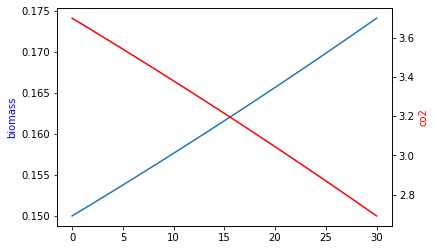

In [69]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('biomass', color='b')
ax2.set_ylabel('co2', color='r')

In [70]:
def add_dynamic_bounds(modelMVA, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, co2 = y  # expand the boundary species
    co2_max_import = -48.06 * co2 / (86 + co2)
    modelMVA.reactions.EX_co2_e.lower_bound = co2_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, co2 = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with modelMVA:
        add_dynamic_bounds(modelMVA, y)

        cobra.util.add_lp_feasibility(modelMVA)
        feasibility = cobra.util.fix_objective_as_constraint(modelMVA)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            modelMVA, ['BIOMASS_Ec_SynAuto', 'EX_co2_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with modelMVA:

        add_dynamic_bounds(modelMVA, y)

        cobra.util.add_lp_feasibility(modelMVA)
        feasibility = cobra.util.fix_objective_as_constraint(modelMVA)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [71]:
modelMVA.solver = 'glpk'

ts = np.linspace(0, 30, 100)  # Desired integration resolution and interval
y0 = [0.15, 3.7]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 30.000: : 129it [05:06,  2.38s/it]


In [72]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 126
     njev: 1
      nlu: 12
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.3030303 ,  0.60606061,  0.90909091,  1.21212121,
        1.51515152,  1.81818182,  2.12121212,  2.42424242,  2.72727273,
        3.03030303,  3.33333333,  3.63636364,  3.93939394,  4.24242424,
        4.54545455,  4.84848485,  5.15151515,  5.45454545,  5.75757576,
        6.06060606,  6.36363636,  6.66666667,  6.96969697,  7.27272727,
        7.57575758,  7.87878788,  8.18181818,  8.48484848,  8.78787879,
        9.09090909,  9.39393939,  9.6969697 , 10.        , 10.3030303 ,
       10.60606061, 10.90909091, 11.21212121, 11.51515152, 11.81818182,
       12.12121212, 12.42424242, 12.72727273, 13.03030303, 13.33333333,
       13.63636364, 13.93939394, 14.24242424, 14.54545455, 14.84848485,
       15.15151515, 15.45454545, 15.75757576, 16.06060606, 16.36363636,
       16.66666667, 16.96969

Text(0, 0.5, 'co2')

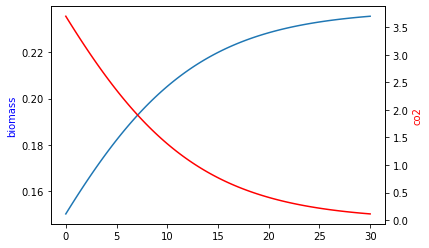

In [73]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('biomass', color='b')
ax2.set_ylabel('co2', color='r')

<a id='4.6'></a>
### 4.6 Assessment of the predicted strains

In [74]:
#ratio_flux = modelM.problem.Constraint(
#    modelM.reactions.get_by_id('EX_sql_e').flux_expression - ratio* modelQO.reactions.get_by_id("BIOMASS_Ec_SynAuto").flux_expression,
#    lb=0,
#    ub=0)
#modelQO.add_cons_vars(ratio_flux)

<div style="text-align: justify"> 
Thorughout this report, several analysis algorithms have been applied to the models to find different possible cell factory designs. With this information, the following assessment aims to classify them in order of their appropriateness for squalene production in an industrial scale.
</div>

In [75]:
#Basic models

biomass= 'BIOMASS_Ec_SynAuto'
sql='EX_sql_e'

modelM.medium=mediumAuto
modelMVA.medium=mediumAuto

modelM.objective=biomass
modelMVA.objective=biomass

MaxDCW=[]
MaxSQL=[]
Models=['iJN678mod','iJN678MVA']

In [76]:
MaxDCW.append(modelM.slim_optimize())
MaxDCW.append(modelMVA.slim_optimize())

modelM.objective=sql
modelMVA.objective=sql
MaxSQL.append(modelM.slim_optimize())
MaxSQL.append(modelMVA.slim_optimize())

In [77]:
#OptGene

with modelM:
    Models.append('FnorKO')
    modelM.reactions.FNOR.knock_out()
    modelM.objective=biomass
    MaxDCW.append(modelM.slim_optimize())
    modelM.objective=sql
    MaxSQL.append(modelM.slim_optimize())
    
with modelM:
    Models.append('Fnor_TrdrKO')
    modelM.reactions.FNOR.knock_out()
    modelM.reactions.TRDR.knock_out()
    modelM.objective=biomass
    MaxDCW.append(modelM.slim_optimize())
    modelM.objective=sql
    MaxSQL.append(modelM.slim_optimize())

with modelM:
    Models.append('AllKo')
    modelM.reactions.FNOR.knock_out()
    modelM.reactions.PSII.knock_out()
    modelM.reactions.ARGN.knock_out()
    modelM.reactions.ACP1_FMN.knock_out()    
    modelM.objective=biomass
    MaxDCW.append(modelM.slim_optimize())
    modelM.objective=sql
    MaxSQL.append(modelM.slim_optimize())
    
    

In [78]:
with modelMVA:
    Models.append('MVA_AllKO')
    modelMVA.reactions.SUCDu_syn.knock_out()
    modelMVA.reactions.PIuabcpp.knock_out()
    modelMVA.reactions.SUCDi.knock_out()
    modelMVA.reactions.SUCDpp_syn.knock_out()
    modelMVA.objective=biomass
    MaxDCW.append(modelMVA.slim_optimize())
    modelMVA.objective=sql
    MaxSQL.append(modelMVA.slim_optimize())
    
with modelMVA:
    Models.append('MVA_HCO3eKO')
    modelMVA.reactions.HCO3E.knock_out()
    modelMVA.reactions.PIuabcpp.knock_out()
    modelMVA.reactions.TDPDRR.knock_out()
    modelMVA.objective=biomass
    MaxDCW.append(modelMVA.slim_optimize())
    modelMVA.objective=sql
    MaxSQL.append(modelMVA.slim_optimize())
    
with modelMVA:
    Models.append('MVA_ACACT1rKO')
    modelMVA.reactions.SUCDu_syn.knock_out()
    modelMVA.reactions.PIuabcpp.knock_out()
    modelMVA.objective=biomass
    MaxDCW.append(modelMVA.slim_optimize())
    modelMVA.objective=sql
    MaxSQL.append(modelMVA.slim_optimize())
    



In [79]:
Models.append('modelOE')
modelOE.medium=mediumAuto
modelOE.objective=biomass
MaxDCW.append(modelOE.slim_optimize())
modelOE.objective=sql
MaxSQL.append(modelOE.slim_optimize())

In [80]:
comp=pandas.DataFrame({'Model':Models, 'MaxDCW':MaxDCW, 'MaxSql': MaxSQL})
comp

Model        MaxDCW        MaxSql
0      iJN678mod  4.966807e-03  7.720588e-03
1      iJN678MVA  8.713131e-02  1.233333e-01
2         FnorKO  4.966807e-03  7.720588e-03
3    Fnor_TrdrKO  4.966807e-03  7.720588e-03
4          AllKo  1.898830e-15 -3.281184e-15
5      MVA_AllKO  5.122314e-15  1.233333e-01
6    MVA_HCO3eKO  1.208350e-14  9.761409e-02
7  MVA_ACACT1rKO -3.744424e-15  1.233333e-01
8        modelOE  4.418558e-02  6.165433e-02

<a id='6'></a>
## 5. Discussion 

<div style="text-align: justify"> 
After the multiple and diverse studies carried out in this report, several notable points can be highlighted. Firstly, through the analysis of the different growth conditions for <i>Synechocystis</i>, we can see that the maximum productivity and yield is achieved under autotrophic growth, that is, by taking advantage of its photosynthetic machinery, reinforcing the sustainability advantages advertised in the introduction. This is clearly shown in the representation of the phenotypic phase planes, which also include microaerobic conditions, with similar results to the heterotrophic ones. However, through this representation the limitations of the chosen model are made clear, there is a bifurcation between biomass and squalene production, as represented in <i>Figure 8</i>, which means that concessions will have to be made.
</div>

<center><img src="Figures/bifurcation.png"/></center>

<center> Figure 8: Simplified view of the flux distribution through the model. <center>

<div style="text-align: justify"> 
Nonetheless,  squalene yield, that is, the slope of this directly proportional relationship, can be raised, allowing for an improved squalene production. This was tried with the addition of the mevalonate pathway. Unfortunately, this proved unsuccessful, as the maximum yield was not improved. 
</div>
<p>
<div style="text-align: justify"> 
    Now, to further improve the cell factory potential of <i>Synechocystis</i>, a suite of optimization algorithms can be applied to both models. Starting with the heuristic method OptGene, which returns various knockout strategies, intended to improve the production of the compound of interest. Unfortunately, it can be seen that the maximum possible flux is not increased in either of the models, and again, the linear relationship is maintained in the majority of the flux space. Moreover, the FSEOF that has been carried out shows that a higher rate in several reactions does not provoke any deviation from the linearity and that, in some cases, the overexpression of the recommended enzymes does not actually improve the overall biomass/squalene relationship but rather it reduces its yield. Finally, the last algorithm applied is OptSwap, which has only managed to increase the production in 1.9%, a rather low value.
</div>
<p>
<div style="text-align: justify"> 
Seeing this, we have decided to apply a rational approach to the problem at hand. This has allowed us to find the optimal growth rate for <i>Synechocystis</i> for squalene production, which confirms that the bifurcation can not be avoided since it coincides with half of the maximum possible growth. Furthermore, this analysis was used to confirm several targets for optimization in the pathway of interest, which include SQLS, DXPS, IPDDI and GRTT.
</div>
<p>
<div style="text-align: justify"> 
To end the analysis, the two basic models have been analysed by means of a dynamic FBA, showing that a biomass of 0.235 g<sub>DCW</sub> can be achieved after 30 hours in a batch cultivation under autotrophic conditions, starting with a 0.15 g<sub>DCW</sub> inoculum. Evidently, this biomass concentration would not be achieved under squalene production, due to the ever-present bifurcation. However, from the resulting kinetics an approximate concentration profile for squalene can be deduced, following the growth of the microorganisms.
</div>
<p>
<div style="text-align: justify"> 
And lastly, representative models for each analysis have been compared with each other in order to evaluate the designs that have been obtained throughout the whole study.
</div>

<a id='6'></a>
## 6. Conclusion

<div style="text-align: justify"> 
Through the analysis of the iJN678 model, we have found that the relationship between biomass and squalene production abides a direct proportion. Therefore, a concession has to be made between each productivity. This is due to the limitations of our current knowledge of <i>Synechocystis</i>, which creates gaps in the working models at our disposal. In this way, even though their great usefulness has been proven elsewhere, the design algorithms applied throughout our report have returned unsatisfactory results in regard to our production objective. 

    
Nonetheless, this opens the gate to new avenues of investigation. For example, the advantages of a kinetic model can reduce the strong dependence on this linear relationship, ensuring a more faithful simulation of the production of squalene. Furthermore, an optimization of the media can be used as a different approach to the problem at hand. However, this would require additional experimental data. Lastly, if a more experimental project were to be defined, the integration of Omics data would highly reinforce the current model.

In conclusion, this study highlights the fact that <i>Synechocystis</i> shows promise for the production of squalene, but emphasises the fact that further research is needed to ensure accurate predictions for our optimization goals.

</div>

<a id='7'></a>
## References

<div style="text-align: justify">
ALLIED MARKET RESEARCH (2022). Squalene market by source (Animal, Vegetable and Synthetci Biotechnology), End use industry (Cosmetics, Nutraceuticals and Healthcare): Global opportunity analysis and industry forecast, 2021-2030. [online]. [Visited: 18th October 2022]. Available at: https://www.alliedmarketresearch.com/squalene-market 
</div>
<br>
<div style="text-align: justify">
Bentley, F. K., Zurbriggen, A., & Melis, A. (2014). Heterologous expression of the mevalonic acid pathway in cyanobacteria enhances endogenous carbon partitioning to isoprene. Molecular Plant, 7(1), 71–86. https://doi.org/10.1093/mp/sst134 
</div>
<br>
<div style="text-align: justify">
Červený, J., Sinetova, M. A., Zavřel, T., & Los, D. A. (2015). Mechanisms of high temperature resistance of <i>Synechocystis sp.</i> PCC 6803: an impact of histidine kinase 34. Life, 5(1), 676-699. https://doi.org/10.3390/life5010676 
</div>
<br>
<div style="text-align: justify">
Choi, S. Y., Sim, S. J., Ko, S. C., Son, J., Lee, J. S., Lee, H. J., Chang, W. S., & Woo, H. M. (2020). Scalable Cultivation of Engineered Cyanobacteria for Squalene Production from Industrial Flue Gas in a Closed Photobioreactor. Journal of Agricultural and Food Chemistry, 68(37), 10050–10055. https://doi.org/10.1021/acs.jafc.0c03133 
</div>
<br>
<div style="text-align: justify">
Choi, S. Y., Wang, J. Y., Kwak, H. S., Lee, S. M., Um, Y., Kim, Y., Sim, S. J., Choi, J. il, & Woo, H. M. (2017). Improvement of Squalene Production from CO<sub>2</sub> in <i>Synechococcus elongatus</i> PCC 7942 by Metabolic Engineering and Scalable Production in a Photobioreactor. ACS Synthetic Biology, 6(7), 1289–1295. https://doi.org/10.1021/acssynbio.7b00083 
</div>
<br>
<div style="text-align: justify">
Ciriminna, R., Pandarus, V., Béland, F., & Pagliaro, M. (2014). Catalytic hydrogenation of squalene to squalane. Organic Process Research & Development, 18(9), 1110-1115. https://doi.org/10.1021/op5002337  
</div>
<br>
<div style="text-align: justify">
Doshi, R., Nguyen, T., & Chang, G. (2013). Transporter-mediated biofuel secretion. Proceedings of the National Academy of Sciences, 110(19), 7642-7647. https://doi.org/10.1073/pnas.1301358110  
</div>
<br>
<div style="text-align: justify">
Englund, E., Pattanaik, B., Ubhayasekera, S. J. K., Stensjö, K., Bergquist, J., & Lindberg, P. (2014). Production of squalene in <i>Synechocystis sp.</i> PCC 6803. PloS one, 9(3), e90270. https://doi.org/10.1371/journal.pone.0090270  
</div>
<br>
<div style="text-align: justify">
Englund, Elias (2016). Metabolic Engineering of <i>Synechocystis sp.</i> PCC 6803 for Terpenoid Production. [Doctoral dissertation Uppsala Universitiet]. https://www.diva-portal.org/smash/get/diva2:1049208/FULLTEXT01.pdf  
</div>
<br>
<div style="text-align: justify">
Gohil, N., Bhattacharjee, G., Khambhati, K., Braddick, D., & Singh, V. (2019). Engineering strategies in microorganisms for the enhanced production of squalene: advances, challenges and opportunities. Frontiers in bioengineering and biotechnology, 7, 50. https://doi.org/10.3389/fbioe.2019.00050 
</div>
<br>
<div style="text-align: justify">
GRAND VIEW RESEARCH (2020). Squalene Market Size, Share & Trends Analysis Report By Source (Animal, Plants, Synthetic), By End-use (Personal Care & Cosmetics, Nutraceuticals), By Region, And Segment Forecasts, 2022 – 2030 [online]. [Visited: 18th October 2022]. Available at: https://www.grandviewresearch.com/industry-analysis/squalene-market  
</div>
<br>
<div style="text-align: justify">
Hari, A., & Lobo, D. (2020). Fluxer: a web application to compute, analyze and visualize genome-scale metabolic flux networks. Nucleic acids research, 48(W1), W427-W435.
</div>
<br>
<div style="text-align: justify">
Iijima, H., Nakaya, Y., Kuwahara, A., Hirai, M. Y., & Osanai, T. (2015). Seawater cultivation of freshwater cyanobacterium <i>Synechocystis sp.</i> PCC 6803 drastically alters amino acid composition and glycogen metabolism. Frontiers in microbiology, 6, 326. https://doi.org/10.3389%2Ffmicb.2015.00326 
</div>
<br>
<div style="text-align: justify">
Joshi, C. J., Peebles, C. A., & Prasad, A. (2017). Modeling and analysis of flux distribution and bioproduct formation in <i>Synechocystis sp.</i> PCC 6803 using a new genome-scale metabolic reconstruction. Algal research, 27, 295-310. https://doi.org/10.1016/j.algal.2017.09.013 
</div>
<br>
<div style="text-align: justify">
Kim, S. K., & Karadeniz, F. (2012). Biological importance and applications of squalene and squalane. Advances in food and nutrition research, 65, 223-233. https://doi.org/10.1016/B978-0-12-416003-3.00014-7 
</div>
<br>
<div style="text-align: justify">
Lieven, C., Beber, M. E., Olivier, B. G., Bergmann, F. T., Ataman, M., Babaei, P., ... & Zhang, C. (2020). MEMOTE for standardized genome-scale metabolic model testing. Nature biotechnology, 38(3), 272-276. https://doi.org/10.1038/s41587-020-0446-y 
</div>
<br>
<div style="text-align: justify">
Liu, X., Sheng, J., & Curtiss III, R. (2011). Fatty acid production in genetically modified cyanobacteria. Proceedings of the National Academy of Sciences, 108(17), 6899-6904. https://doi.org/10.1073/pnas.1103014108 
</div>
<br>
<div style="text-align: justify">
Lozano-Grande, M. A., Gorinstein, S., Espitia-Rangel, E., Dávila-Ortiz, G., & Martínez-Ayala, A. L. (2018). Plant sources, extraction methods, and uses of squalene. International journal of agronomy, 2018. https://doi.org/10.1155/2018/1829160  
</div>
<br>
<div style="text-align: justify">
Mohammadi, R., Fallah-Mehrabadi, J., Bidkhori, G., Zahiri, J., Niroomand, M. J., & Masoudi-Nejad, A. (2016). A systems biology approach to reconcile metabolic network models with application to <i>Synechocystis sp.</i> PCC 6803 for biofuel production. Molecular BioSystems, 12(8), 2552-2561. https://doi.org/10.1039/C6MB00119J 
</div>
<br>
<div style="text-align: justify">
Nguyen, B. T., & Rittmann, B. E. (2016). Effects of inorganic carbon and pH on growth kinetics of Synechocystis sp. PCC 6803. Algal research, 19, 363-369.    
<div class="csl-entry">
<br>
<div style="text-align: justify">
Nogales, J., Gudmundsson, S., Knight, E. M., Palsson, B. O., & Thiele, I. (2012). Detailing the optimality of photosynthesis in cyanobacteria through systems biology analysis. Proceedings of the National Academy of Sciences, 109(7), 2678-2683. https://doi.org/10.1073/pnas.1117907109 
</div>
<br>
<div style="text-align: justify">
Pan, J. J., Solbiati, J. O., Ramamoorthy, G., Hillerich, B. S., Seidel, R. D., Cronan, J. E., ... & Poulter, C. D. (2015). Biosynthesis of squalene from farnesyl diphosphate in bacteria: three steps catalyzed by three enzymes. ACS central science, 1(2), 77-82. https://doi.org/10.1021/acscentsci.5b00115 
</div>
<br>
<div style="text-align: justify">
Paramasivan, K., & Sarma Mutturi, ·. (2022). Recent advances in the microbial production of squalene. World Journal of Microbiology and Biotechnology, 38, 91–92. https://doi.org/10.1007/s11274-022-03273-w 
</div>
<br>
<div style="text-align: justify">
Pattanaik, B., Englund, E., Nolte, N., & Lindberg, P. (2020). Introduction of a green algal squalene synthase enhances squalene accumulation in a strain of <i>Synechocystis sp.</i> PCC 6803. Metabolic engineering communications, 10, e00125. https://doi.org/10.1016/j.mec.2020.e00125  
</div>
<br>
<div style="text-align: justify">
Pembroke, J. T., Armshaw, P., & Ryan, M. P. (2019). Metabolic engineering of the model photoautotrophic cyanobacterium <i>Synechocystis</i> for ethanol production: Optimization strategies and challenges. Fuel Ethanol Production from Sugarcane; Basso, TP, Basso, LC, Eds, 199-219. https://doi.org/10.5772/INTECHOPEN.77271  
</div>
<br>
<div style="text-align: justify">
Sánchez, A. M., Andrews, J., Hussein, I., Bennett, G. N., & San, K. Y. (2006). Effect of Overexpression of a Soluble Pyridine Nucleotide Transhydrogenase (UdhA) on the Production of Poly(3-hydroxybutyrate) in <i>Escherichia coli</i>. Biotechnology Progress, 22(2), 420–425. https://doi.org/10.1021/BP050375U 
</div>
<br>
<div style="text-align: justify">
Srivastava, A. K., Rai, A. N., & Neilan, B. A. (Eds.). (2013). Stress biology of cyanobacteria: molecular mechanisms to cellular responses. CRC Press.  
</div>
<br>
<div style="text-align: justify">
Tan, X., Yao, L., Gao, Q., Wang, W., Qi, F., & Lu, X. (2011). Photosynthesis driven conversion of carbon dioxide to fatty alcohols and hydrocarbons in cyanobacteria. Metabolic engineering, 13(2), 169-176. https://doi.org/10.1016/j.ymben.2011.01.001 
</div>
<br>
<div style="text-align: justify">
Xiao, Y., Chu, L., Sanakis, Y., & Liu, P. (2009). Revisiting the IspH catalytic system in the deoxyxylulose phosphate pathway: Achieving high activity. Journal of the American Chemical Society, 131(29), 9931–9933. https://doi.org/10.1021/ja903778d 
</div>
<br>
<div style="text-align: justify">
Xu, W., Yao, J., Liu, L., Ma, X., Li, W., Sun, X., & Wang, Y. (2019). Improving squalene production by enhancing the NADPH/NADP+ ratio, modifying the isoprenoid-feeding module and blocking the menaquinone pathway in <i>Escherichia coli</i>. Biotechnology for Biofuels, 12(1), 1–9. https://doi.org/10.1186/s13068-019-1415-x 
</div>
<br>
<div style="text-align: justify">
Yajima, S., Hara, K., Iino, D., Sasaki, Y., Kuzuyama, T., Ohsawa, K., & Seto, H. (2007). F63, 466-470 Acta Crystallographica Section F. Structure Communications 466 Acta Cryst. https://doi.org/10.1107/S1744309107024475 
</div>
<br>
<div style="text-align: justify">
Yu, Y., You, L., Liu, D., Hollinshead, W., Tang, Y. J., & Zhang, F. (2013). Development of <i>Synechocystis sp.</i> PCC 6803 as a phototrophic cell factory. Marine drugs, 11(8), 2894-2916. https://doi.org/10.3390/md11082894    
</div>
<br>
<div style="text-align: justify">
Zhu, Z. T., Du, M. M., Gao, B., Tao, X. Y., Zhao, M., Ren, Y. H., ... & Wei, D. Z. (2021). Metabolic compartmentalization in yeast mitochondria: Burden and solution for squalene overproduction. Metabolic engineering, 68, 232-245. https://doi.org/10.1016/j.ymben.2021.10.011
</div>